<a href="https://colab.research.google.com/github/swarna-deep007/Weather_Forecasting/blob/main/demonstration_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd

#Download Dataset



In [8]:
india = pd.read_csv("/content/4109917.csv")
japan= pd.read_csv("/content/4112203.csv")

/tmp/ipython-input-4000193662.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  india = pd.read_csv("/content/4109917.csv")


#Data Understanding and Cleaning

In [9]:
india.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217531 entries, 0 to 217530
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   STATION          217531 non-null  object 
 1   NAME             217531 non-null  object 
 2   LATITUDE         217531 non-null  float64
 3   LONGITUDE        217531 non-null  float64
 4   ELEVATION        217531 non-null  float64
 5   DATE             217531 non-null  object 
 6   PRCP             94596 non-null   float64
 7   PRCP_ATTRIBUTES  94596 non-null   object 
 8   SNWD             4 non-null       float64
 9   SNWD_ATTRIBUTES  4 non-null       object 
 10  TAVG             217531 non-null  int64  
 11  TAVG_ATTRIBUTES  217531 non-null  object 
 12  TMAX             164326 non-null  float64
 13  TMAX_ATTRIBUTES  164326 non-null  object 
 14  TMIN             160420 non-null  float64
 15  TMIN_ATTRIBUTES  160420 non-null  object 
dtypes: float64(7), int64(1), object(8)
mem

In [10]:
japan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220119 entries, 0 to 220118
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   STATION          220119 non-null  object 
 1   NAME             220119 non-null  object 
 2   LATITUDE         220119 non-null  float64
 3   LONGITUDE        220119 non-null  float64
 4   ELEVATION        220119 non-null  float64
 5   DATE             220119 non-null  object 
 6   PRCP             157476 non-null  float64
 7   PRCP_ATTRIBUTES  157476 non-null  object 
 8   SNWD             9403 non-null    float64
 9   SNWD_ATTRIBUTES  9403 non-null    object 
 10  TAVG             220118 non-null  float64
 11  TAVG_ATTRIBUTES  220118 non-null  object 
 12  TMAX             184618 non-null  float64
 13  TMAX_ATTRIBUTES  184618 non-null  object 
 14  TMIN             120729 non-null  float64
 15  TMIN_ATTRIBUTES  120729 non-null  object 
dtypes: float64(8), object(8)
memory usage:

In [11]:
prcp_unique_india = india["PRCP_ATTRIBUTES"].unique()
print(prcp_unique_india)
prcp_unique_japan = japan["PRCP_ATTRIBUTES"].unique()
print(prcp_unique_japan)
tavg__unique_india = india["TAVG_ATTRIBUTES"].unique()
print(tavg__unique_india)
tavg__unique_japan = japan["TAVG_ATTRIBUTES"].unique()
print(tavg__unique_japan)
tmin__unique_india = india["TMIN_ATTRIBUTES"].unique()
print(tmin__unique_india)
tmin__unique_japan = japan["TMIN_ATTRIBUTES"].unique()
print(tmin__unique_japan)
tmax__unique_india = india["TMAX_ATTRIBUTES"].unique()
print(tmax__unique_india)
tmax__unique_japan = japan["TMAX_ATTRIBUTES"].unique()
print(tmax__unique_japan)
snwd_unique_japan = japan["SNWD_ATTRIBUTES"].unique()
print(snwd_unique_japan)

['D,,S' nan ',,S' ',O,S' 'B,,S' ',G,S']
['B,,S' nan ',,S' ',S,S' 'B,K,S' ',O,S' ',,I' ',K,S']
['H,,S']
['H,,S' nan]
[nan ',,S' ',O,S' ',I,S']
[',,S' nan ',I,S' ',,G' ',,I' ',I,G']
[',,S' nan ',O,S' ',I,S']
[',,S' nan ',I,S' ',,G' ',I,I']
[',,S' nan ',W,S']


# Attribute Codes in NOAA GHCN Data

Each attribute has the form:

- **Measurement Flag** → how the value was measured/derived.  
- **Quality Flag** → if the value failed QC checks.  
- **Source Flag** → where the data came from.  

---

## Meaning of Common Flags

**Measurement Flags**
- B = Two 12-hour totals (derived)  
- D = Incomplete daily total  
- H = Highest hourly temp  
- I = Interpolated  
- G = Generated/fill  

**Quality Flags**
- (blank) = Passed QC  
- O = Outlier  
- I = Internal consistency fail  
- G = Gap check fail  
- K = Streak/frequency fail  

**Source Flags**
- S = GSOD  
- I = ISH  
- G = COOP  
- K = Automated weather stations  
- O = Other official sources  

---

## Good vs Bad Codes (from India & Japan datasets)

**✅ Good**
- `,,S` (clean GSOD)  
- `,,I` (clean ISH)  
- `,S,S` (valid, flagged by source)  
- `H,,S` (valid highest hourly temp)  

**⚠️ Borderline (use with caution)**
- `B,,S` (two 12-hour totals)  
- `D,,S` (incomplete daily total)  

**❌ Bad (drop or flag)**
- `,O,S` (outlier)  
- `,I,S` (internal consistency fail)  
- `,G,S` (gap fail)  
- `B,K,S` (derived + streak fail)  
- `,K,S` (streak fail)  
- `,,G` (gap fail)  
- `,I,G` (interpolated + gap fail)  
- `,I,I` (interpolated + ISH)  
- `nan` (missing)  


In [12]:
import pandas as pd

# Define categories

good_flags = {"", ",,S", ",,I", ",S,S", "H,,S"}
borderline_flags = {"B,,S", "D,,S", ",W,S"}
bad_flags = {",O,S", ",I,S", ",G,S", "B,K,S", ",K,S", ",,G", ",I,G", ",I,I"}

def classify_attribute(value):
    """Classify NOAA attribute codes into Good, Borderline, or Bad."""
    if pd.isna(value):
        return "Bad"   # treat missing as bad
    if value in good_flags:
        return "Good"
    elif value in borderline_flags:
        return "Borderline"
    elif value in bad_flags:
        return "Bad"
    else:
        return "Unknown"  # in case new codes appear

# Example: classify attributes in India dataset
india["PRCP_quality"] = india["PRCP_ATTRIBUTES"].apply(classify_attribute)
india["TAVG_quality"] = india["TAVG_ATTRIBUTES"].apply(classify_attribute)
india["TMIN_quality"] = india["TMIN_ATTRIBUTES"].apply(classify_attribute)
india["TMAX_quality"] = india["TMAX_ATTRIBUTES"].apply(classify_attribute)
india["SNWD_quality"] = india["SNWD_ATTRIBUTES"].apply(classify_attribute)
# Same for Japan dataset
japan["PRCP_quality"] = japan["PRCP_ATTRIBUTES"].apply(classify_attribute)
japan["TAVG_quality"] = japan["TAVG_ATTRIBUTES"].apply(classify_attribute)
japan["TMIN_quality"] = japan["TMIN_ATTRIBUTES"].apply(classify_attribute)
japan["TMAX_quality"] = japan["TMAX_ATTRIBUTES"].apply(classify_attribute)
japan["SNWD_quality"] = japan["SNWD_ATTRIBUTES"].apply(classify_attribute)

# Quick summary
print(india["PRCP_quality"].value_counts())
print(japan["PRCP_quality"].value_counts())


PRCP_quality
Bad           122945
Good           61985
Borderline     32601
Name: count, dtype: int64
PRCP_quality
Borderline    102357
Bad            62662
Good           55100
Name: count, dtype: int64


In [13]:
# Function to count quality per station for each attribute, sorted by Good
def count_quality_per_station(df, attr_list):
    results = {}
    for attr in attr_list:
        quality_col = f"{attr}_quality"
        if quality_col not in df.columns:
            continue
        # Count per station
        counts = df.groupby("NAME")[quality_col].value_counts().unstack(fill_value=0)
        # Ensure all categories exist
        for cat in ["Good", "Borderline", "Bad"]:
            if cat not in counts.columns:
                counts[cat] = 0
        # Sort by Good descending
        counts = counts.sort_values(by="Good", ascending=False)
        results[attr] = counts
    return results

# Attributes we care about
attributes = ["PRCP", "TAVG", "TMIN", "TMAX","SNWD"]

# Get counts for India and Japan
india_counts = count_quality_per_station(india, attributes)
japan_counts = count_quality_per_station(japan, attributes)

# Show results
for attr, table in india_counts.items():
    print(f"\nIndia – {attr} Quality Counts per Station (sorted by Good):")
    display(table)

for attr, table in japan_counts.items():
    print(f"\nJapan – {attr} Quality Counts per Station (sorted by Good):")
    display(table)



India – PRCP Quality Counts per Station (sorted by Good):


PRCP_quality              Bad  Borderline  Good
NAME                                           
DIBRUGARH MOHANBAR, IN   4199         917  7029
BANGALORE, IN            5561        2115  5223
BHUBANESWAR, IN          6060        2243  4597
DEHRADUN, IN             5527        1704  4471
BOMBAY SANTACRUZ, IN     5743        2871  4358
CALCUTTA DUM DUM, IN     6678        2288  3973
COIMBATORE PEELAMED, IN  6675        2497  3653
BHOPAL BAIRAGARH, IN     6824        2749  3210
CUDDALORE, IN            6889        2890  3109
AMRITSAR, IN             7883        1861  2764
BAREILLY, IN             6721        1391  2733
AHMADABAD, IN            7131        3370  2394
AKOLA, IN                5498         341  1881
DALTONGANJ, IN           4681           0  1695
ALLAHABAD, IN            4155        1294  1421
DHUBRI, IN               1764           0  1347
CALCUTTA ALIPORE, IN     2162           0  1338
BIKANER, IN              6226        3138  1216
CHANDIGARH IAFB, IN      2399           0  1089
BHAGALPUR, IN            5718         430  1089
COOCH BEHAR, IN          1156           0  1022
BAHRAICH, IN             2678           0   824
BHAUNAGAR, IN            2755           0   552
CHANDRAPUR, IN           1468           0   473
BARMER, IN               6300         502   402
CHERRAPUNJI, IN            94           0   122


India – TAVG Quality Counts per Station (sorted by Good):


TAVG_quality              Good  Borderline  Bad
NAME                                           
BOMBAY SANTACRUZ, IN     12972           0    0
CALCUTTA DUM DUM, IN     12939           0    0
BHUBANESWAR, IN          12900           0    0
BANGALORE, IN            12899           0    0
AHMADABAD, IN            12895           0    0
CUDDALORE, IN            12888           0    0
COIMBATORE PEELAMED, IN  12825           0    0
BHOPAL BAIRAGARH, IN     12783           0    0
AMRITSAR, IN             12508           0    0
DIBRUGARH MOHANBAR, IN   12145           0    0
DEHRADUN, IN             11702           0    0
BAREILLY, IN             10845           0    0
BIKANER, IN              10580           0    0
AKOLA, IN                 7720           0    0
BHAGALPUR, IN             7237           0    0
BARMER, IN                7204           0    0
ALLAHABAD, IN             6870           0    0
DALTONGANJ, IN            6376           0    0
BAHRAICH, IN              3502           0    0
CALCUTTA ALIPORE, IN      3500           0    0
CHANDIGARH IAFB, IN       3488           0    0
BHAUNAGAR, IN             3307           0    0
DHUBRI, IN                3111           0    0
COOCH BEHAR, IN           2178           0    0
CHANDRAPUR, IN            1941           0    0
CHERRAPUNJI, IN            216           0    0


India – TMIN Quality Counts per Station (sorted by Good):


TMIN_quality              Bad   Good  Borderline
NAME                                            
BANGALORE, IN            2031  10868           0
CUDDALORE, IN            2105  10783           0
COIMBATORE PEELAMED, IN  2248  10577           0
BOMBAY SANTACRUZ, IN     2789  10183           0
BHUBANESWAR, IN          2893  10007           0
BHOPAL BAIRAGARH, IN     2932   9851           0
DIBRUGARH MOHANBAR, IN   2407   9738           0
BAREILLY, IN             1409   9436           0
AHMADABAD, IN            4146   8749           0
DEHRADUN, IN             3311   8391           0
CALCUTTA DUM DUM, IN     5712   7227           0
AMRITSAR, IN             5459   7049           0
AKOLA, IN                1173   6547           0
BIKANER, IN              4157   6423           0
DALTONGANJ, IN           1075   5301           0
ALLAHABAD, IN            2795   4075           0
BHAUNAGAR, IN              43   3264           0
BARMER, IN               4031   3173           0
BHAGALPUR, IN            4159   3078           0
DHUBRI, IN                134   2977           0
CHANDIGARH IAFB, IN       558   2930           0
CALCUTTA ALIPORE, IN      616   2884           0
BAHRAICH, IN              714   2788           0
COOCH BEHAR, IN            59   2119           0
CHANDRAPUR, IN            154   1787           0
CHERRAPUNJI, IN            15    201           0


India – TMAX Quality Counts per Station (sorted by Good):


TMAX_quality              Bad   Good  Borderline
NAME                                            
BANGALORE, IN            1203  11696           0
CUDDALORE, IN            1749  11139           0
COIMBATORE PEELAMED, IN  1812  11013           0
AMRITSAR, IN             1902  10606           0
DEHRADUN, IN             1347  10355           0
BIKANER, IN               414  10166           0
BAREILLY, IN             1270   9575           0
CALCUTTA DUM DUM, IN     3647   9292           0
BHUBANESWAR, IN          3802   9098           0
BHOPAL BAIRAGARH, IN     4077   8706           0
DIBRUGARH MOHANBAR, IN   4029   8116           0
BOMBAY SANTACRUZ, IN     5150   7822           0
AHMADABAD, IN            5811   7084           0
BARMER, IN                908   6296           0
ALLAHABAD, IN             711   6159           0
DALTONGANJ, IN            363   6013           0
AKOLA, IN                3565   4155           0
BHAGALPUR, IN            3283   3954           0
CHANDIGARH IAFB, IN        35   3453           0
BAHRAICH, IN             1074   2428           0
BHAUNAGAR, IN             971   2336           0
DHUBRI, IN               1037   2074           0
CHANDRAPUR, IN            689   1252           0
COOCH BEHAR, IN          1018   1160           0
CALCUTTA ALIPORE, IN     3163    337           0
CHERRAPUNJI, IN           209      7           0


India – SNWD Quality Counts per Station (sorted by Good):


SNWD_quality               Bad  Good  Borderline
NAME                                            
DEHRADUN, IN             11699     3           0
AMRITSAR, IN             12507     1           0
AKOLA, IN                 7720     0           0
ALLAHABAD, IN             6870     0           0
BAHRAICH, IN              3502     0           0
BANGALORE, IN            12899     0           0
BAREILLY, IN             10845     0           0
BARMER, IN                7204     0           0
BHAGALPUR, IN             7237     0           0
AHMADABAD, IN            12895     0           0
BHAUNAGAR, IN             3307     0           0
BHOPAL BAIRAGARH, IN     12783     0           0
BIKANER, IN              10580     0           0
BHUBANESWAR, IN          12900     0           0
CALCUTTA ALIPORE, IN      3500     0           0
CALCUTTA DUM DUM, IN     12939     0           0
CHANDIGARH IAFB, IN       3488     0           0
BOMBAY SANTACRUZ, IN     12972     0           0
CHANDRAPUR, IN            1941     0           0
CHERRAPUNJI, IN            216     0           0
COOCH BEHAR, IN           2178     0           0
COIMBATORE PEELAMED, IN  12825     0           0
CUDDALORE, IN            12888     0           0
DALTONGANJ, IN            6376     0           0
DHUBRI, IN                3111     0           0
DIBRUGARH MOHANBAR, IN   12145     0           0


Japan – PRCP Quality Counts per Station (sorted by Good):


PRCP_quality    Bad  Borderline  Good
NAME                                 
CHOSHI, JA      920        2405  9657
FUKUOKA, JA    3344        2253  7019
FUKUI, JA      2821        3520  5604
GIFU, JA       3320        3026  5604
AOMORI, JA     2937        4289  5390
AKITA, JA      4174        3053  5389
ASAHIKAWA, JA  2803        4430  5382
ABASHIRI, JA   3420        3905  5290
CHIBA, JA      3677        6040  2227
FUKUE, JA      3230        7570  1811
ESASHI, JA     3014        8175  1159
FUKAURA, JA    3373        8884   341
CHICHIBU, JA   5289        6925    93
ABURATSU, JA   3993        7201    37
AKUNE, JA      4344        7247    26
FUKUYAMA, JA   4380        6834    25
FUSHIKI, JA    4107        8168    25
HABORO, JA     3516        8432    21


Japan – TAVG Quality Counts per Station (sorted by Good):


TAVG_quality   Bad   Good  Borderline
NAME                                 
CHOSHI, JA       1  12981           0
AKITA, JA        0  12616           0
AOMORI, JA       0  12616           0
FUKUOKA, JA      0  12616           0
ASAHIKAWA, JA    0  12615           0
ABASHIRI, JA     0  12615           0
FUKUE, JA        0  12611           0
FUKAURA, JA      0  12598           0
ESASHI, JA       0  12348           0
CHICHIBU, JA     0  12307           0
FUSHIKI, JA      0  12300           0
HABORO, JA       0  11969           0
GIFU, JA         0  11950           0
FUKUI, JA        0  11945           0
CHIBA, JA        0  11944           0
AKUNE, JA        0  11617           0
FUKUYAMA, JA     0  11239           0
ABURATSU, JA     0  11231           0


Japan – TMIN Quality Counts per Station (sorted by Good):


TMIN_quality    Bad  Good  Borderline
NAME                                 
FUKAURA, JA    5722  6876           0
FUKUOKA, JA    5783  6833           0
FUKUE, JA      5822  6789           0
CHICHIBU, JA   5531  6776           0
AOMORI, JA     5868  6748           0
ABASHIRI, JA   5869  6746           0
ESASHI, JA     5670  6678           0
ASAHIKAWA, JA  5940  6675           0
AKITA, JA      5942  6674           0
GIFU, JA       5302  6648           0
FUSHIKI, JA    5675  6625           0
CHIBA, JA      5445  6499           0
AKUNE, JA      5265  6352           0
FUKUYAMA, JA   4921  6318           0
FUKUI, JA      5707  6238           0
HABORO, JA     5793  6176           0
ABURATSU, JA   5078  6153           0
CHOSHI, JA     8077  4905           0


Japan – TMAX Quality Counts per Station (sorted by Good):


TMAX_quality    Bad   Good  Borderline
NAME                                  
CHICHIBU, JA    687  11620           0
FUSHIKI, JA     987  11313           0
FUKUI, JA       683  11262           0
GIFU, JA        784  11166           0
CHIBA, JA       939  11005           0
AKUNE, JA       807  10810           0
FUKUYAMA, JA    538  10701           0
FUKAURA, JA    1989  10609           0
ABURATSU, JA    765  10466           0
ESASHI, JA     2104  10244           0
HABORO, JA     2135   9834           0
FUKUOKA, JA    2896   9720           0
FUKUE, JA      3135   9476           0
ASAHIKAWA, JA  3140   9475           0
AKITA, JA      3323   9293           0
AOMORI, JA     3345   9271           0
ABASHIRI, JA   3919   8696           0
CHOSHI, JA     7346   5636           0


Japan – SNWD Quality Counts per Station (sorted by Good):


SNWD_quality     Bad  Borderline  Good
NAME                                  
ASAHIKAWA, JA  10889           0  1726
ABASHIRI, JA   10960           0  1655
AOMORI, JA     11220           0  1396
AKITA, JA      11517           0  1099
HABORO, JA     10911           0  1058
FUSHIKI, JA    11724           0   576
FUKUI, JA      11428           0   517
ESASHI, JA     11909           0   439
CHICHIBU, JA   11870           4   433
FUKAURA, JA    12191           0   407
GIFU, JA       11888           0    62
FUKUOKA, JA    12602           0    14
CHIBA, JA      11931           0    13
FUKUE, JA      12608           0     3
AKUNE, JA      11616           0     1
ABURATSU, JA   11231           0     0
CHOSHI, JA     12982           0     0
FUKUYAMA, JA   11239           0     0

In [14]:
def get_top_stations(df, attr, top_n=10):
    """Return top N stations with most Good values for a given attribute."""
    quality_col = f"{attr}_quality"
    # Count Good per station
    good_counts = df[df[quality_col] == "Good"].groupby("STATION").size().sort_values(ascending=False)
    top_stations = good_counts.head(top_n).index
    return df[df["STATION"].isin(top_stations)]

# =============================
# India Datasets
# =============================

# Heavy Rainfall (PRCP, Top 10 stations)
india_rainfall = get_top_stations(india, "PRCP", top_n=10)[
    ["STATION", "NAME", "LATITUDE", "LONGITUDE", "ELEVATION", "DATE", "PRCP"]
]

# Heatstorm/Coldstorm (TAVG, Top 10 stations)
india_temp = get_top_stations(india, "TAVG", top_n=10)[
    ["STATION", "NAME", "LATITUDE", "LONGITUDE", "ELEVATION", "DATE", "TAVG", "TMIN", "TMAX"]
]

# =============================
# Japan Datasets
# =============================

# Heavy Rainfall (PRCP, Top 10 stations)
japan_rainfall = get_top_stations(japan, "PRCP", top_n=10)[
    ["STATION", "NAME", "LATITUDE", "LONGITUDE", "ELEVATION", "DATE", "PRCP"]
]

# Heatstorm/Coldstorm (TAVG, Top 10 stations)
japan_temp = get_top_stations(japan, "TAVG", top_n=10)[
    ["STATION", "NAME", "LATITUDE", "LONGITUDE", "ELEVATION", "DATE", "TAVG", "TMIN", "TMAX"]
]

# Snowstorm (SNWD, Top 5 stations)
japan_snow = get_top_stations(japan, "SNWD", top_n=5)[
    ["STATION", "NAME", "LATITUDE", "LONGITUDE", "ELEVATION", "DATE", "SNWD"]
]

# =============================
# Preview
# =============================
print("India Rainfall:", india_rainfall.shape)
print("India Temp:", india_temp.shape)
print("Japan Rainfall:", japan_rainfall.shape)
print("Japan Temp:", japan_temp.shape)
print("Japan Snow:", japan_snow.shape)


India Rainfall: (126561, 7)
India Temp: (127754, 9)
Japan Rainfall: (124510, 7)
Japan Temp: (125924, 9)
Japan Snow: (62431, 7)


In [15]:
a = india_rainfall["NAME"].unique()
print(a)
b = india_temp["NAME"].unique()
print(b)
c = japan_rainfall["NAME"].unique()
print(c)
d = japan_temp["NAME"].unique()
print(d)
e = japan_snow["NAME"].unique()
print(e)

['CALCUTTA DUM DUM, IN' 'AMRITSAR, IN' 'DIBRUGARH MOHANBAR, IN'
 'BOMBAY SANTACRUZ, IN' 'DEHRADUN, IN' 'BANGALORE, IN' 'BHUBANESWAR, IN'
 'BHOPAL BAIRAGARH, IN' 'COIMBATORE PEELAMED, IN' 'CUDDALORE, IN']
['CALCUTTA DUM DUM, IN' 'AMRITSAR, IN' 'DIBRUGARH MOHANBAR, IN'
 'BOMBAY SANTACRUZ, IN' 'BANGALORE, IN' 'BHUBANESWAR, IN'
 'BHOPAL BAIRAGARH, IN' 'COIMBATORE PEELAMED, IN' 'AHMADABAD, IN'
 'CUDDALORE, IN']
['AOMORI, JA' 'GIFU, JA' 'FUKUE, JA' 'AKITA, JA' 'CHIBA, JA' 'CHOSHI, JA'
 'ASAHIKAWA, JA' 'FUKUI, JA' 'ABASHIRI, JA' 'FUKUOKA, JA']
['FUKAURA, JA' 'AOMORI, JA' 'CHICHIBU, JA' 'FUKUE, JA' 'AKITA, JA'
 'CHOSHI, JA' 'ESASHI, JA' 'ASAHIKAWA, JA' 'ABASHIRI, JA' 'FUKUOKA, JA']
['AOMORI, JA' 'HABORO, JA' 'AKITA, JA' 'ASAHIKAWA, JA' 'ABASHIRI, JA']


In [16]:
japan.groupby("NAME")[["LATITUDE","LONGITUDE","ELEVATION"]].nunique()

LATITUDE  LONGITUDE  ELEVATION
NAME                                         
ABASHIRI, JA          1          1          1
ABURATSU, JA          1          1          1
AKITA, JA             1          1          1
AKUNE, JA             1          1          1
AOMORI, JA            1          1          1
ASAHIKAWA, JA         1          1          1
CHIBA, JA             1          1          1
CHICHIBU, JA          1          1          1
CHOSHI, JA            1          1          1
ESASHI, JA            1          1          1
FUKAURA, JA           1          1          1
FUKUE, JA             1          1          1
FUKUI, JA             1          1          1
FUKUOKA, JA           1          1          1
FUKUYAMA, JA          1          1          1
FUSHIKI, JA           1          1          1
GIFU, JA              1          1          1
HABORO, JA            1          1          1

In [17]:
import pandas as pd

# ======================
# CONFIG
# ======================
start_date = "1990-01-01"
end_date = "2025-07-31"
full_range = pd.date_range(start_date, end_date, freq="D")

# ======================
# FUNCTION TO CLEAN DATASET
# ======================
def resample_station(df, value_cols):
    """
    df: dataframe with columns including STATION, NAME, LATITUDE, LONGITUDE, ELEVATION, DATE, ...value_cols
    value_cols: list of weather columns to fill (e.g., ["PRCP"], ["TAVG","TMIN","TMAX"])
    """
    df["DATE"] = pd.to_datetime(df["DATE"])
    filled_groups = []

    for station, g in df.groupby("STATION"):
        # --- metadata ---
        station_meta = {
            "STATION": station,
            "NAME": g["NAME"].iloc[0],
            "LATITUDE": g["LATITUDE"].iloc[0],
            "LONGITUDE": g["LONGITUDE"].iloc[0],
            "ELEVATION": g["ELEVATION"].iloc[0],
        }

        # --- reindex to full daily range 1990-2025 ---
        g = g.set_index("DATE").sort_index()
        g = g.reindex(full_range)

        # --- fill numeric weather values ---
        for col in value_cols:
            if col in g.columns:
                if col in ["PRCP", "SNWD"]:
                    g[col] = g[col].fillna(0)  # missing = 0
                else:  # TAVG, TMIN, TMAX
                    g[col] = g[col].interpolate(method="time").bfill().ffill()

        # --- reset index ---
        g = g.reset_index().rename(columns={"index": "DATE"})

        # --- add metadata ---
        for k, v in station_meta.items():
            g[k] = v

        filled_groups.append(g)

    return pd.concat(filled_groups, ignore_index=True)

# ======================
# APPLY TO EACH DATASET
# ======================

# India Rainfall
india_rainfall_clean = resample_station(india_rainfall, value_cols=["PRCP"])

# India Temperature
india_temp_clean = resample_station(india_temp, value_cols=["TAVG", "TMIN", "TMAX"])

# Japan Rainfall
japan_rainfall_clean = resample_station(japan_rainfall, value_cols=["PRCP"])

# Japan Temperature
japan_temp_clean = resample_station(japan_temp, value_cols=["TAVG", "TMIN", "TMAX"])

# Japan Snowfall
japan_snow_clean = resample_station(japan_snow, value_cols=["SNWD"])


print("✅ All datasets cleaned, filled, and saved.")


✅ All datasets cleaned, filled, and saved.


In [18]:
india_rainfall_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129960 entries, 0 to 129959
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   DATE       129960 non-null  datetime64[ns]
 1   STATION    129960 non-null  object        
 2   NAME       129960 non-null  object        
 3   LATITUDE   129960 non-null  float64       
 4   LONGITUDE  129960 non-null  float64       
 5   ELEVATION  129960 non-null  float64       
 6   PRCP       129960 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 6.9+ MB


In [19]:
india_rainfall_clean.to_csv("India_Rainfall_Clean.csv", index=False)
india_temp_clean.to_csv("India_Temp_Clean.csv", index=False)
japan_rainfall_clean.to_csv("Japan_Rainfall_Clean.csv", index=False)
japan_temp_clean.to_csv("Japan_Temp_Clean.csv", index=False)
japan_snow_clean.to_csv("Japan_Snow_Clean.csv", index=False)

print("✅ All datasets cleaned and saved.")

✅ All datasets cleaned and saved.


In [20]:
japan_snow_clean

DATE      STATION        NAME  LATITUDE  LONGITUDE  ELEVATION  \
0     1990-01-01  JA000047404  HABORO, JA    44.367      141.7       10.0   
1     1990-01-02  JA000047404  HABORO, JA    44.367      141.7       10.0   
2     1990-01-03  JA000047404  HABORO, JA    44.367      141.7       10.0   
3     1990-01-04  JA000047404  HABORO, JA    44.367      141.7       10.0   
4     1990-01-05  JA000047404  HABORO, JA    44.367      141.7       10.0   
...          ...          ...         ...       ...        ...        ...   
64975 2025-07-27  JA000047582   AKITA, JA    39.717      140.1        7.0   
64976 2025-07-28  JA000047582   AKITA, JA    39.717      140.1        7.0   
64977 2025-07-29  JA000047582   AKITA, JA    39.717      140.1        7.0   
64978 2025-07-30  JA000047582   AKITA, JA    39.717      140.1        7.0   
64979 2025-07-31  JA000047582   AKITA, JA    39.717      140.1        7.0   

       SNWD  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
...     ...  
64975   0.0  
64976   0.0  
64977   0.0  
64978   0.0  
64979   0.0  

[64980 rows x 7 columns]

#Exploratory Data Analysis

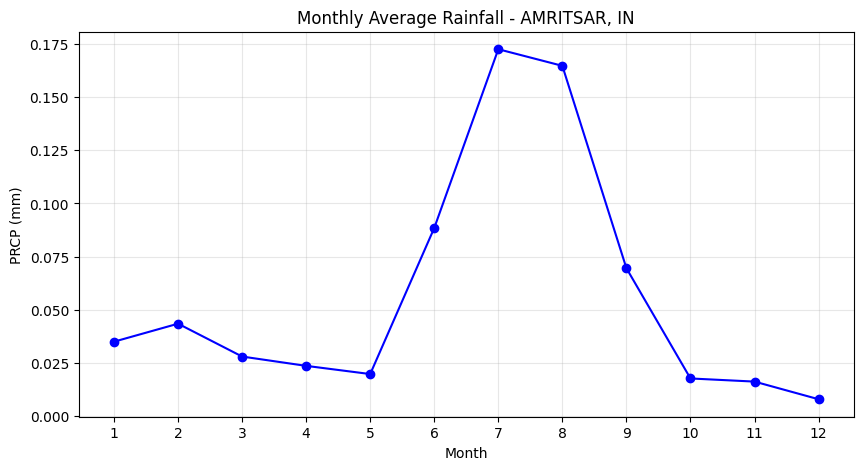

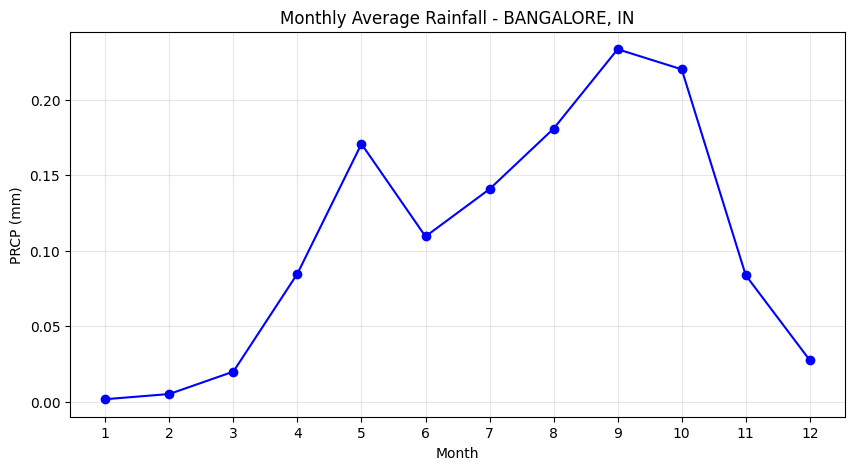

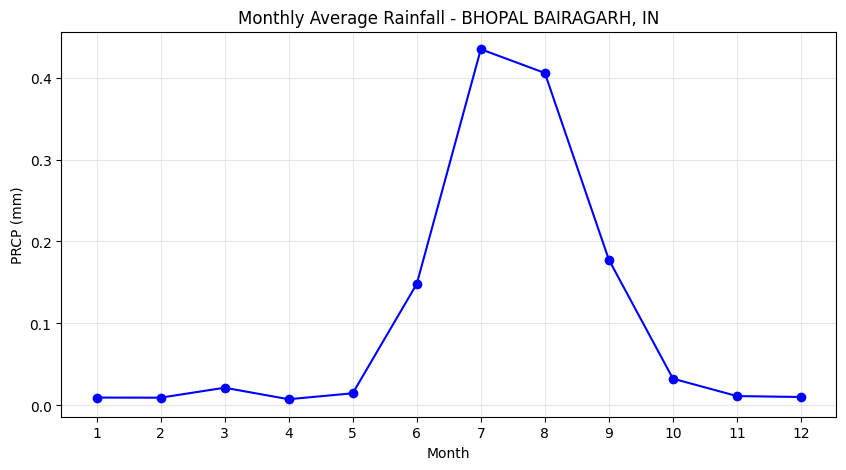

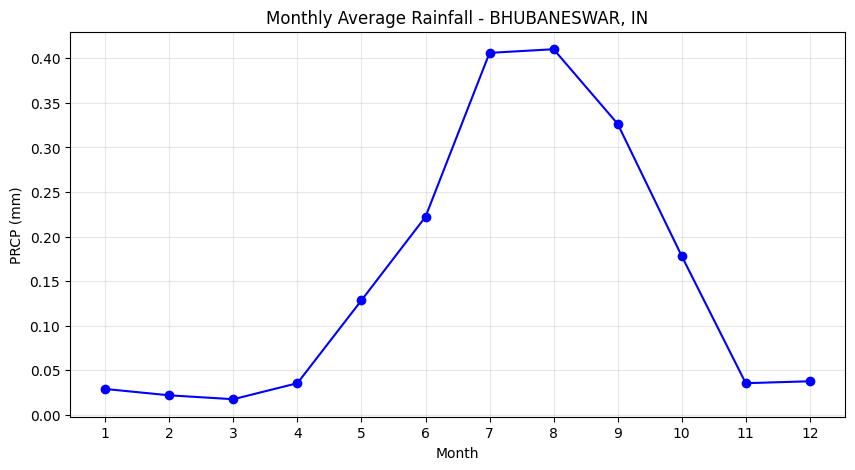

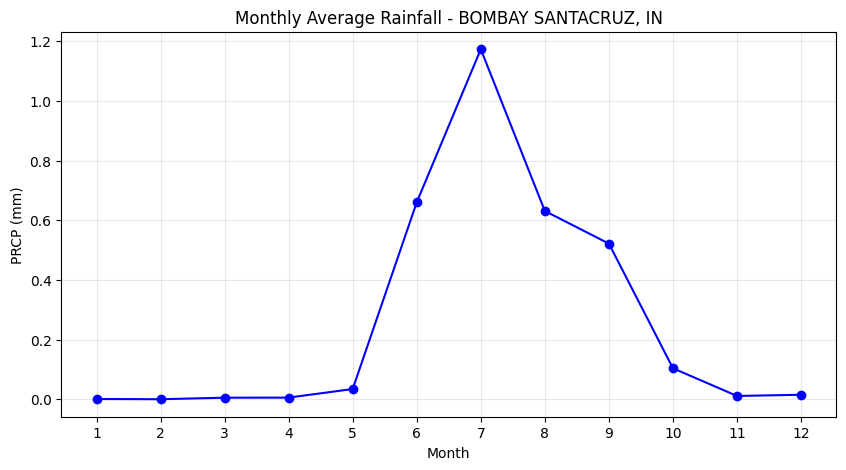

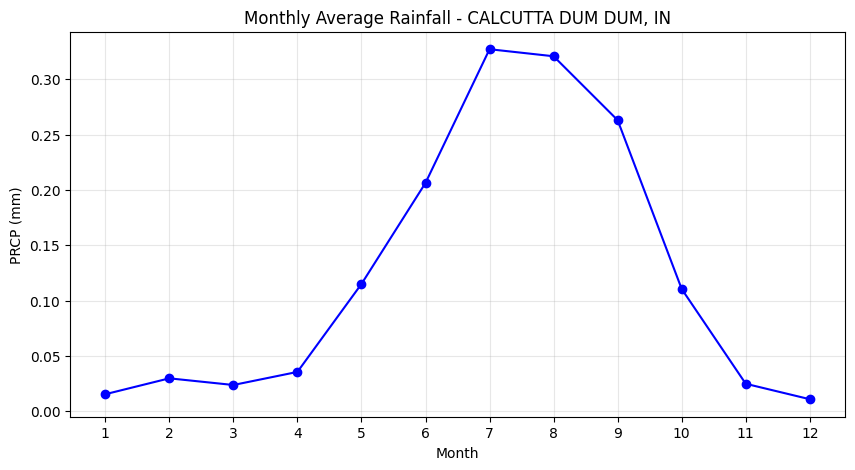

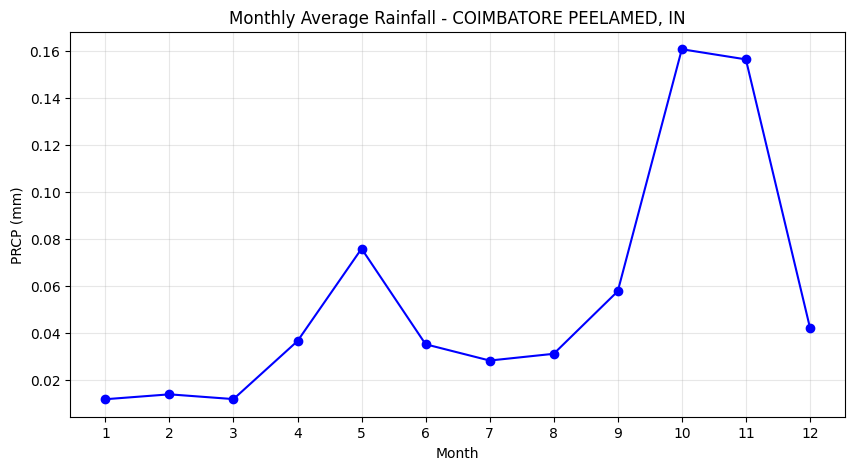

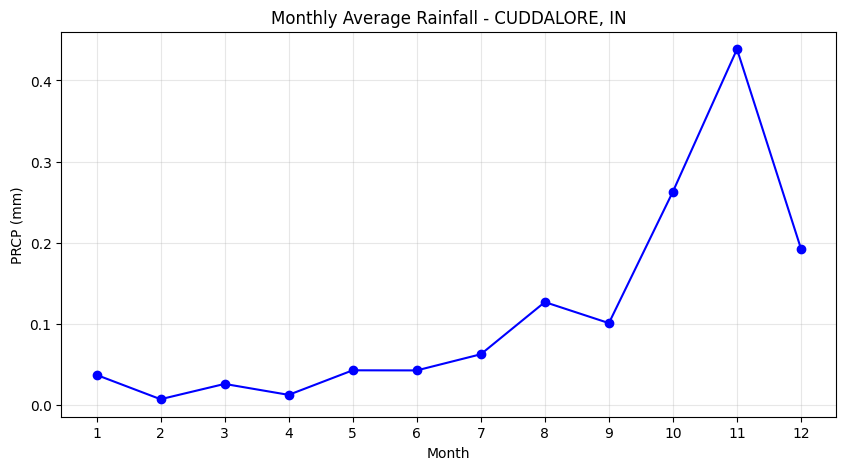

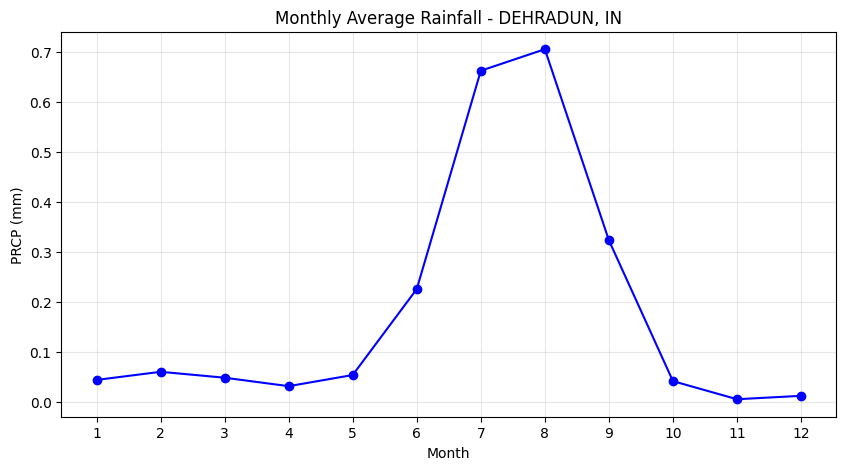

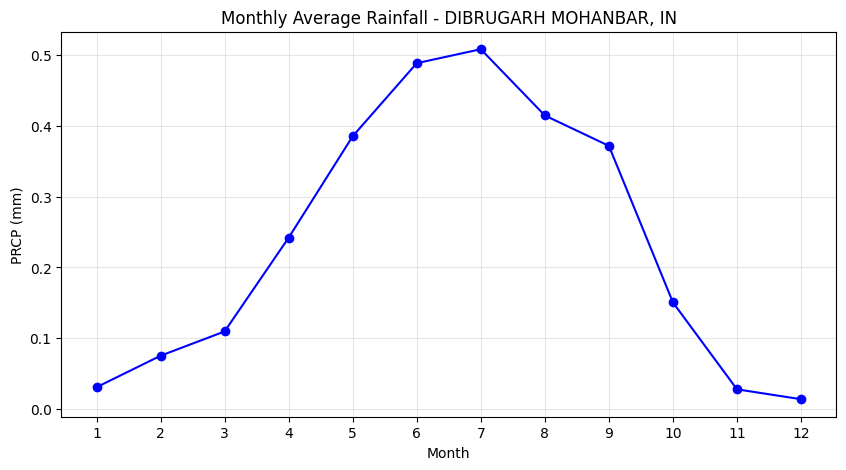

In [21]:
import matplotlib.pyplot as plt

india_rainfall_clean["Month"] = india_rainfall_clean["DATE"].dt.month

for station_name, g in india_rainfall_clean.groupby("NAME"):
    monthly_mean = g.groupby("Month")["PRCP"].mean()

    plt.figure(figsize=(10,5))
    plt.plot(monthly_mean.index, monthly_mean.values, marker='o', color='blue')
    plt.title(f"Monthly Average Rainfall - {station_name}")
    plt.xlabel("Month")
    plt.ylabel("PRCP (mm)")
    plt.xticks(range(1,13))
    plt.grid(alpha=0.3)
    plt.show()


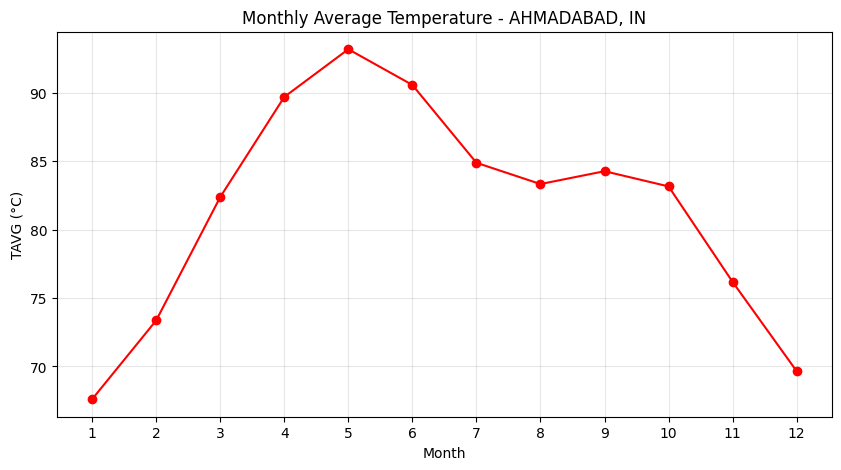

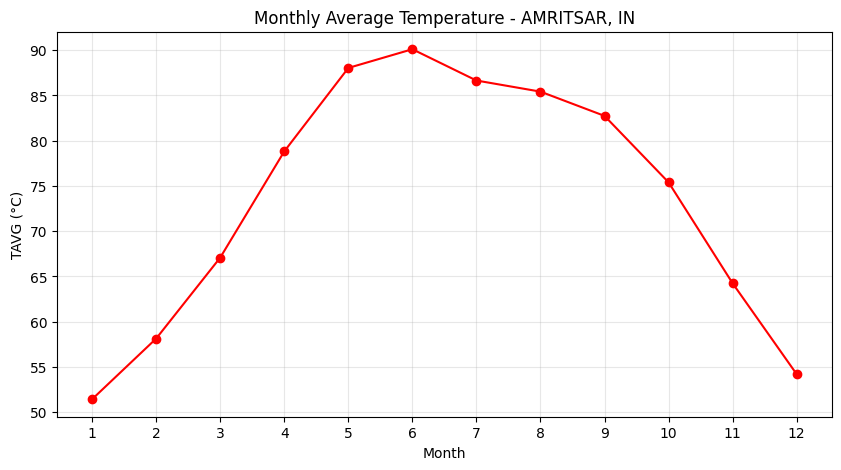

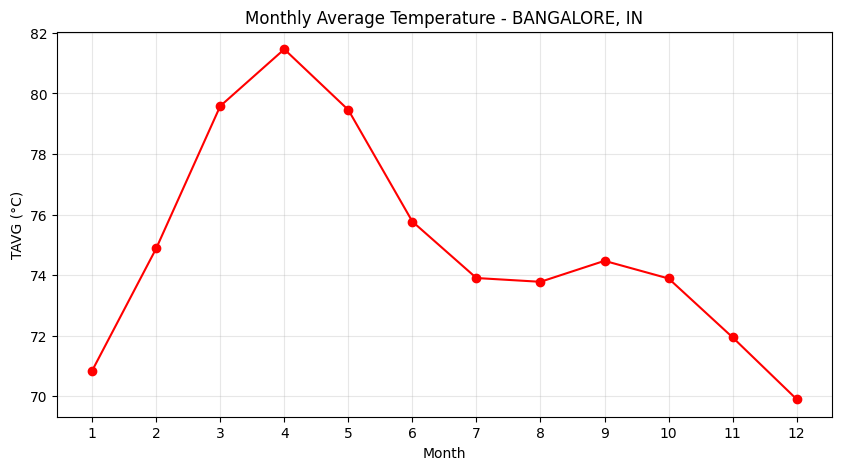

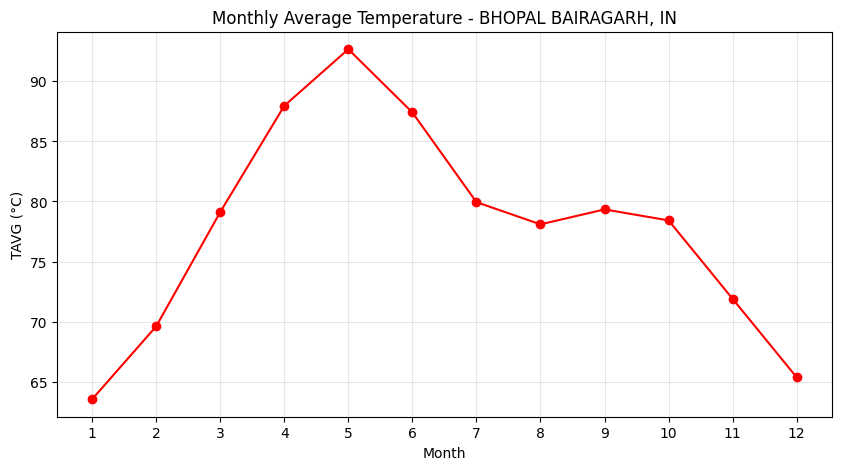

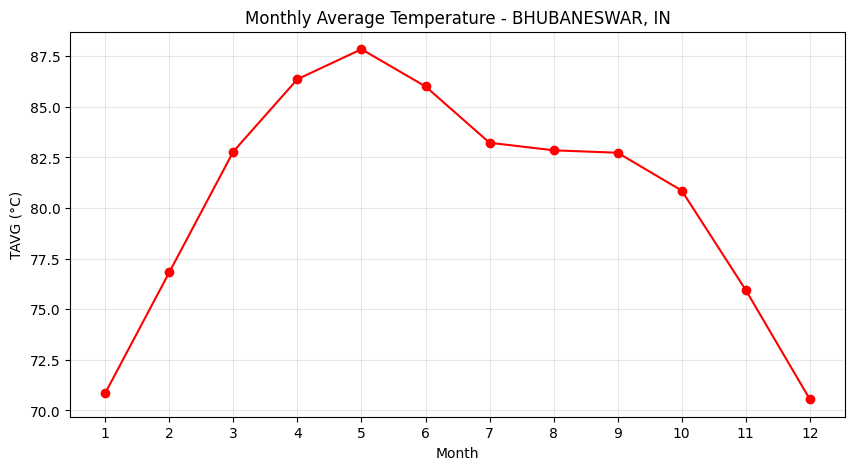

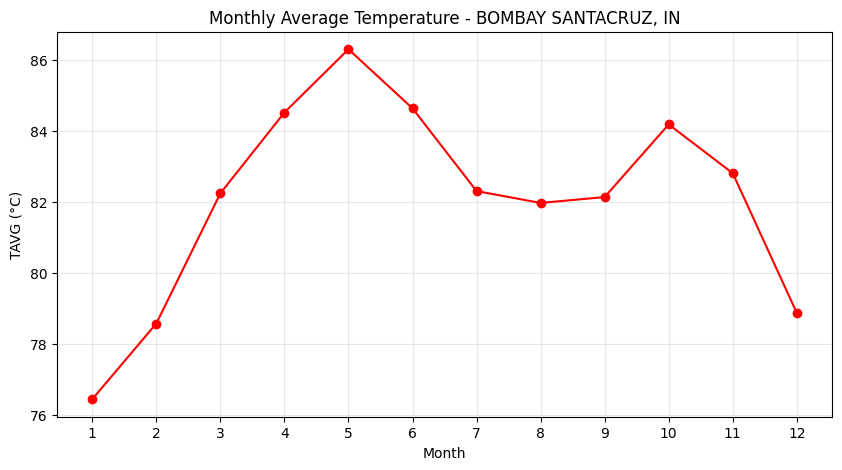

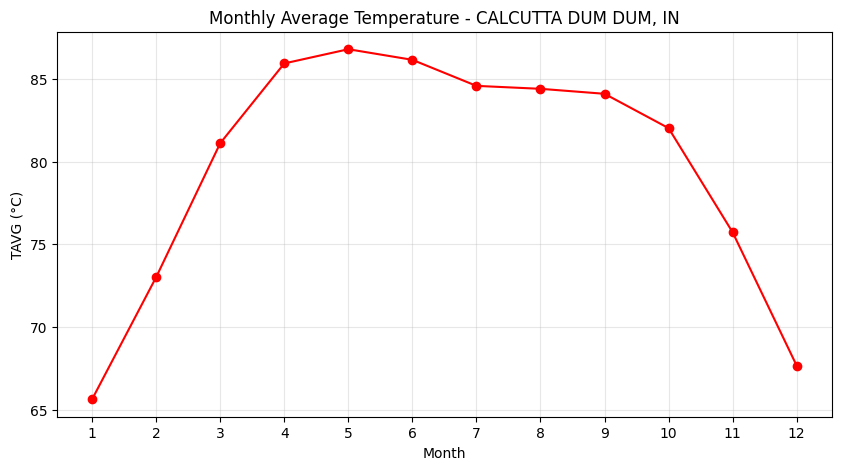

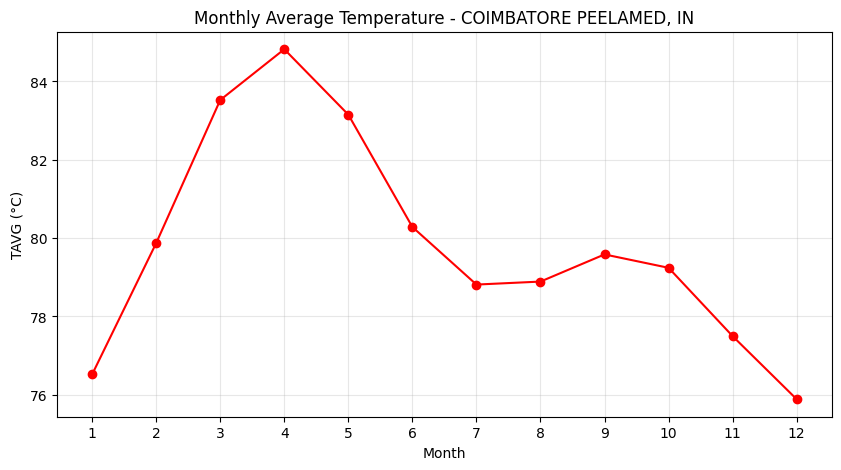

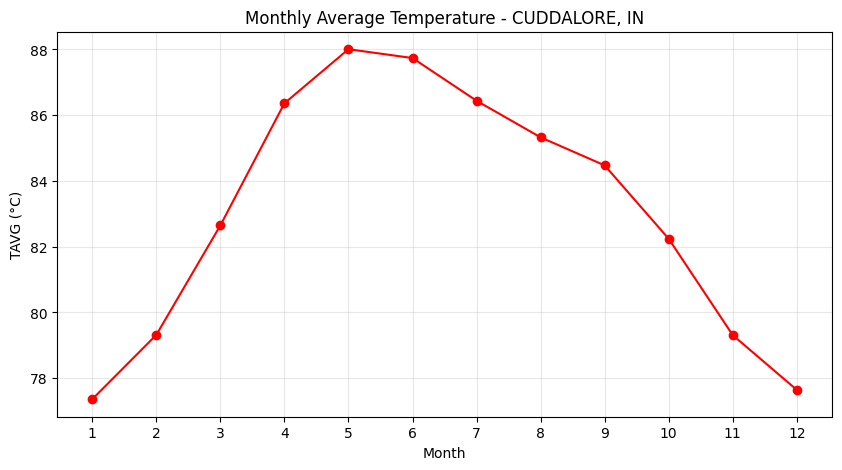

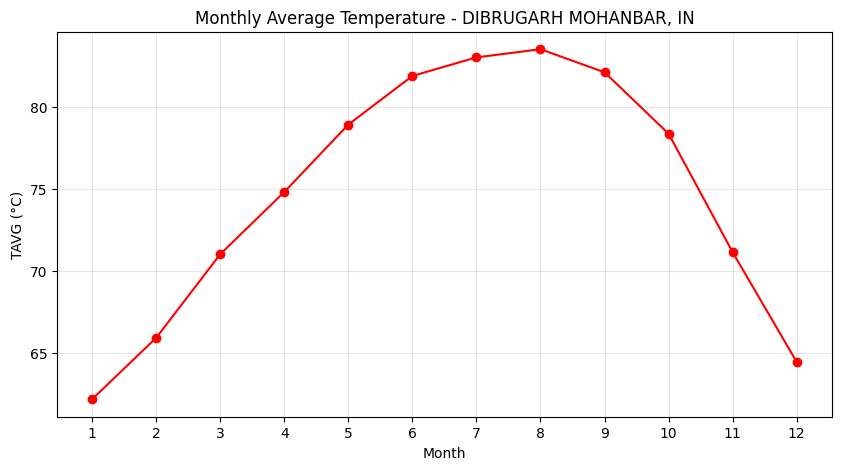

In [22]:
india_temp_clean["Month"] = india_temp_clean["DATE"].dt.month

for station_name, g in india_temp_clean.groupby("NAME"):
    monthly_mean = g.groupby("Month")["TAVG"].mean()

    plt.figure(figsize=(10,5))
    plt.plot(monthly_mean.index, monthly_mean.values, marker='o', color='red')
    plt.title(f"Monthly Average Temperature - {station_name}")
    plt.xlabel("Month")
    plt.ylabel("TAVG (°C)")
    plt.xticks(range(1,13))
    plt.grid(alpha=0.3)
    plt.show()


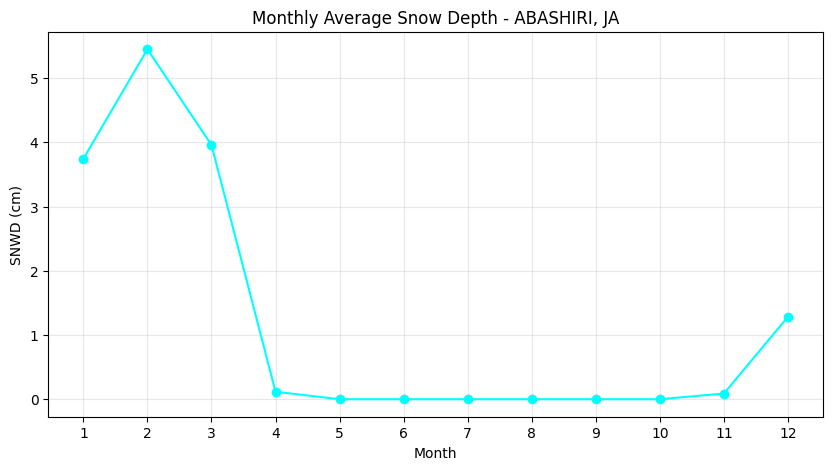

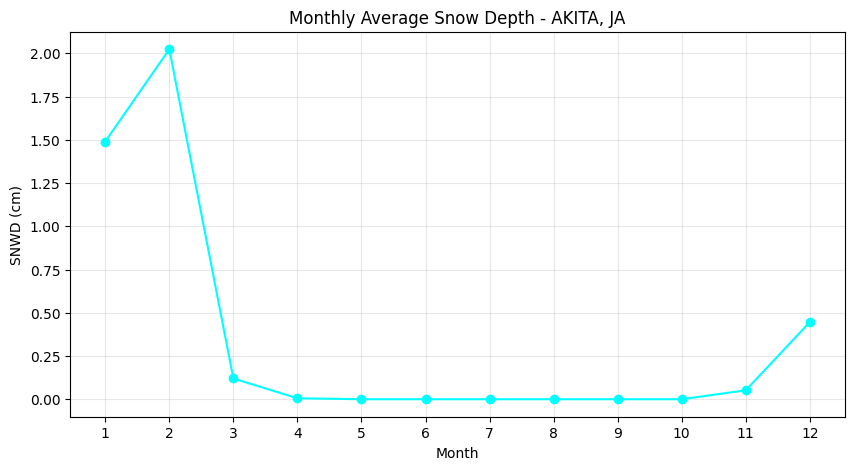

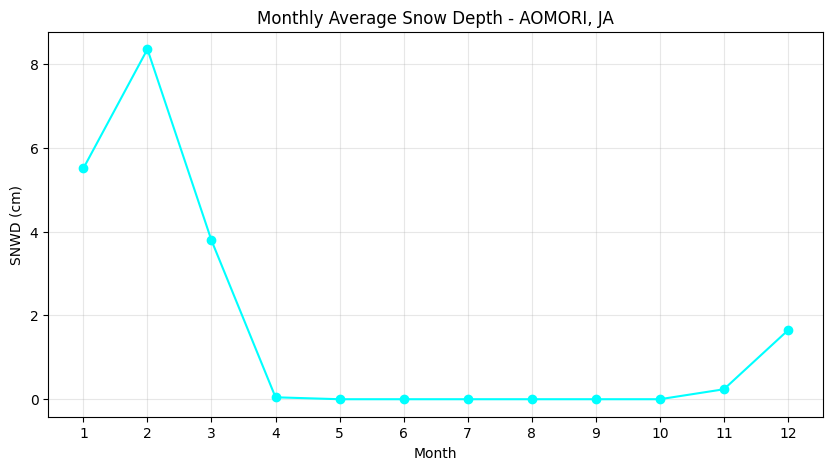

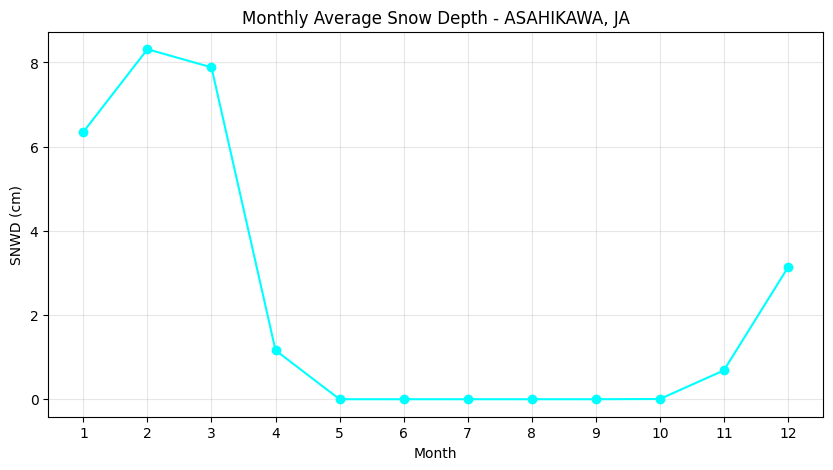

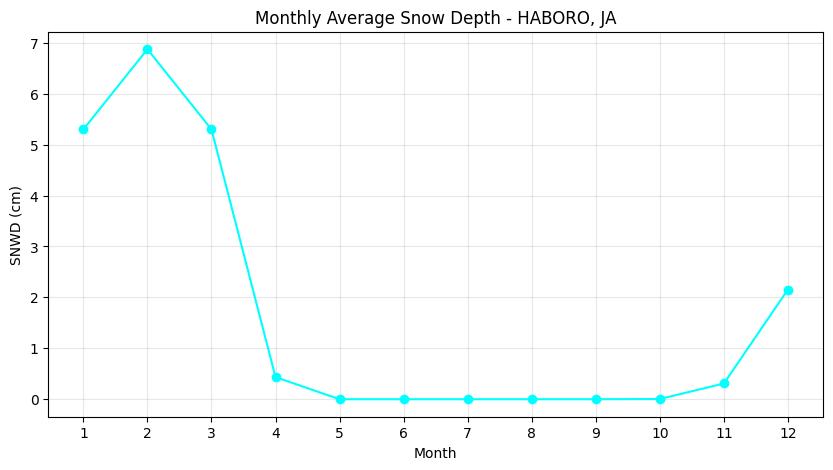

In [23]:
japan_snow_clean["Month"] = japan_snow_clean["DATE"].dt.month

for station_name, g in japan_snow_clean.groupby("NAME"):
    monthly_mean = g.groupby("Month")["SNWD"].mean()

    plt.figure(figsize=(10,5))
    plt.plot(monthly_mean.index, monthly_mean.values, marker='o', color='cyan')
    plt.title(f"Monthly Average Snow Depth - {station_name}")
    plt.xlabel("Month")
    plt.ylabel("SNWD (cm)")
    plt.xticks(range(1,13))
    plt.grid(alpha=0.3)
    plt.show()


In [24]:
# Maximum daily precipitation in India
max_prcp_value = india_rainfall_clean["PRCP"].max()
max_prcp_row = india_rainfall_clean[india_rainfall_clean["PRCP"] == max_prcp_value]

print(f"Highest daily precipitation: {max_prcp_value} mm")
print("Details of that day:")
print(max_prcp_row)


Highest daily precipitation: 18.54 mm
Details of that day:
            DATE      STATION                  NAME  LATITUDE  LONGITUDE  \
26557 1991-07-20  IN011351500  BHOPAL BAIRAGARH, IN    23.283     77.350   
52361 1991-01-13  IN017111200       BHUBANESWAR, IN    20.250     85.833   

       ELEVATION   PRCP  Month  
26557      523.0  18.54      7  
52361       46.0  18.54      1  


In [25]:
max_prcp_japan = japan_rainfall_clean["PRCP"].max()
max_prcp_row_japan = japan_rainfall_clean[japan_rainfall_clean["PRCP"] == max_prcp_japan]

print(f"Highest daily precipitation in Japan: {max_prcp_japan} mm")
print(max_prcp_row_japan)


Highest daily precipitation in Japan: 11.61 mm
             DATE      STATION       NAME  LATITUDE  LONGITUDE  ELEVATION  \
128512 2021-08-14  JA000047843  FUKUE, JA      32.7    128.833       26.0   

         PRCP  
128512  11.61  


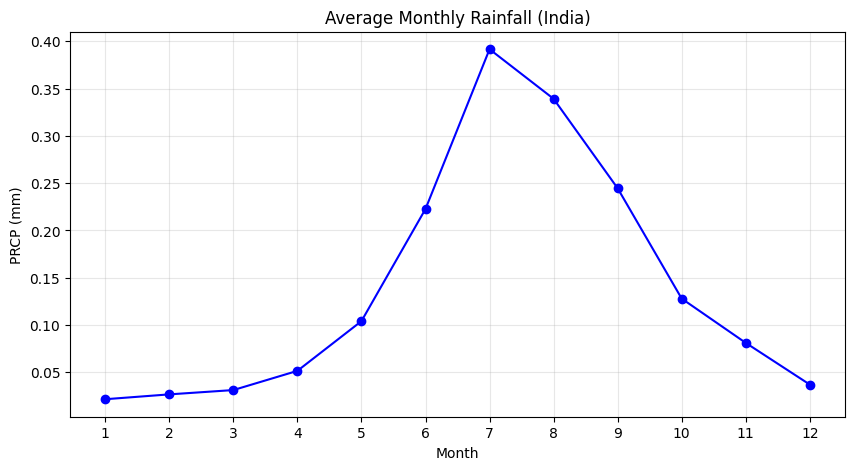

In [26]:
# Monthly mean for all stations
monthly_mean = india_rainfall_clean.groupby(india_rainfall_clean["DATE"].dt.month)["PRCP"].mean()

plt.figure(figsize=(10,5))
plt.plot(monthly_mean.index, monthly_mean.values, marker='o', color='blue')
plt.title("Average Monthly Rainfall (India)")
plt.xlabel("Month")
plt.ylabel("PRCP (mm)")
plt.xticks(range(1,13))
plt.grid(alpha=0.3)
plt.show()


Heavy rainfall threshold: 2.67 mm/day
NAME
BOMBAY SANTACRUZ, IN       371
DEHRADUN, IN               203
DIBRUGARH MOHANBAR, IN     141
BHUBANESWAR, IN            136
CUDDALORE, IN              130
CALCUTTA DUM DUM, IN        94
BHOPAL BAIRAGARH, IN        90
BANGALORE, IN               65
AMRITSAR, IN                35
COIMBATORE PEELAMED, IN     35
dtype: int64


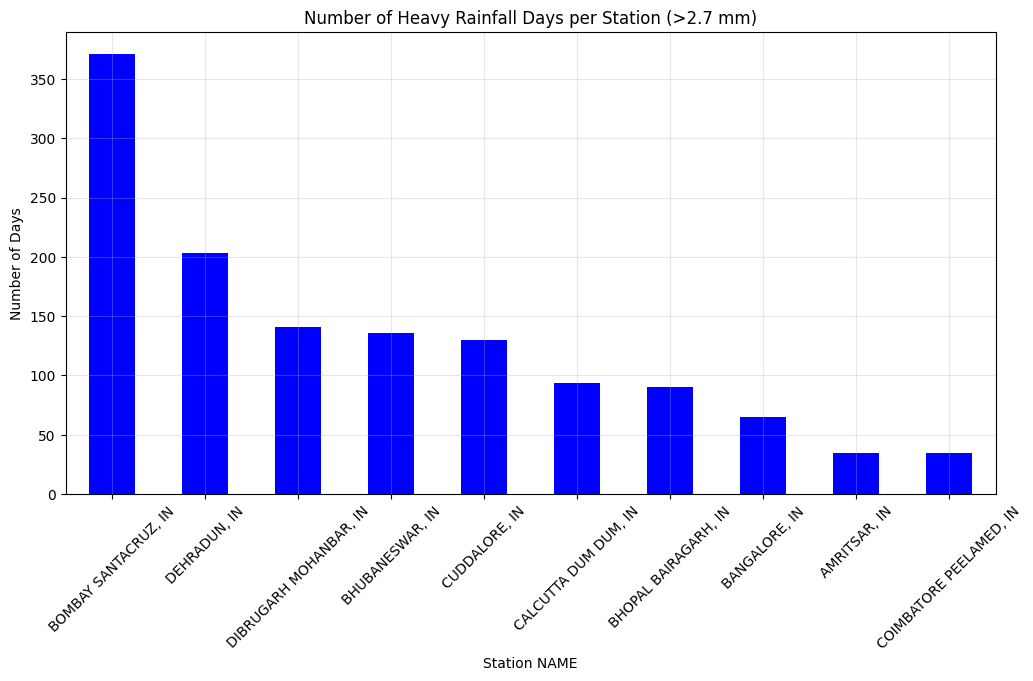

In [27]:
import matplotlib.pyplot as plt


heavy_threshold = india_rainfall_clean["PRCP"].quantile(0.99)
print(f"Heavy rainfall threshold: {heavy_threshold:.2f} mm/day")
# Filter heavy rainfall
heavy_rain = india_rainfall_clean[india_rainfall_clean["PRCP"] > heavy_threshold]

# Count per station
heavy_rain_count = heavy_rain.groupby("NAME").size().sort_values(ascending=False)
print(heavy_rain_count)


plt.figure(figsize=(12,6))
heavy_rain_count.plot(kind="bar", color="blue")
plt.title(f"Number of Heavy Rainfall Days per Station (>{heavy_threshold:.1f} mm)")
plt.xlabel("Station NAME")
plt.ylabel("Number of Days")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()


In [43]:
# Threshold for heavy snow (example: >20 cm/day)
# heavy_snow_threshold = 20
heavy_snow_threshold = japan_snow_clean["SNWD"].quantile(0.99)
print(heavy_snow_threshold)

heavy_snow = japan_snow_clean[japan_snow_clean["SNWD"] > heavy_snow_threshold]

# Count heavy snow days per station
heavy_snow_count = heavy_snow.groupby("NAME").size().sort_values(ascending=False)
print(heavy_snow_count)


29.9
NAME
HABORO, JA       287
ASAHIKAWA, JA    192
AOMORI, JA       163
ABASHIRI, JA       1
dtype: int64


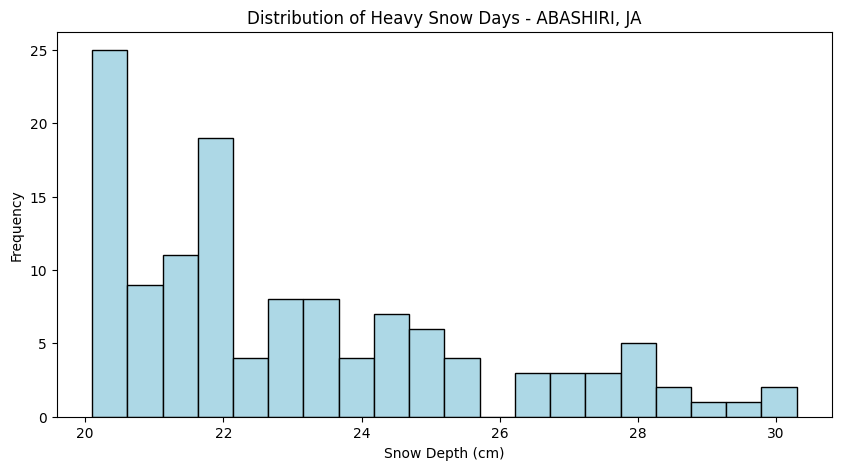

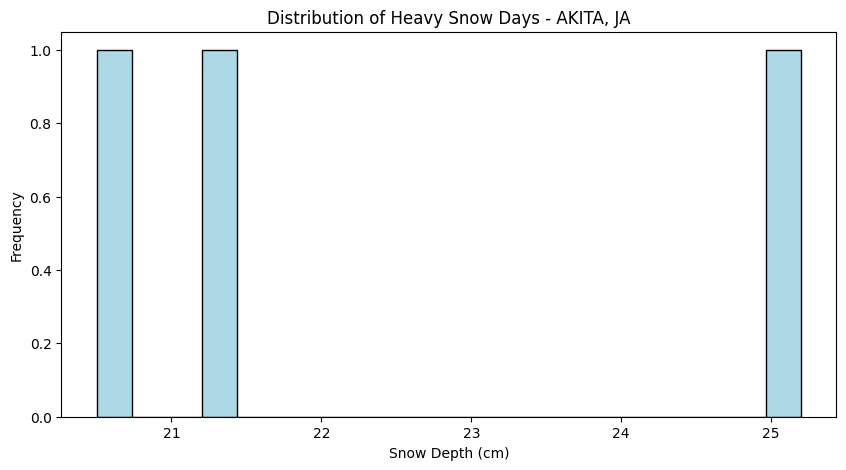

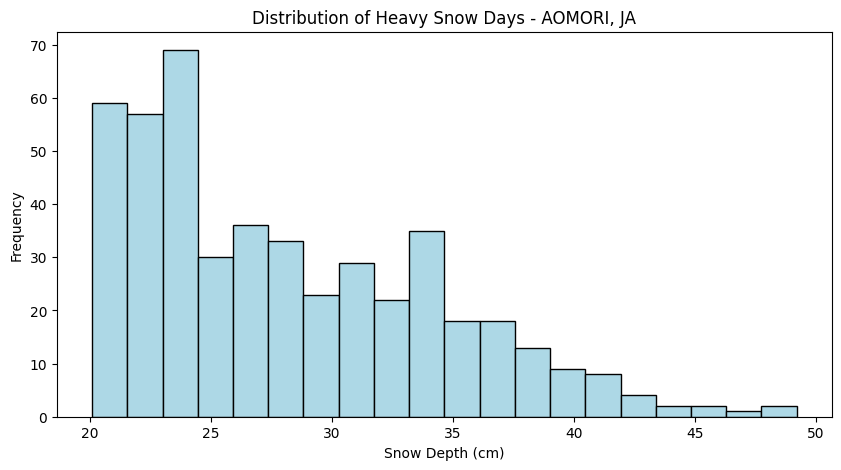

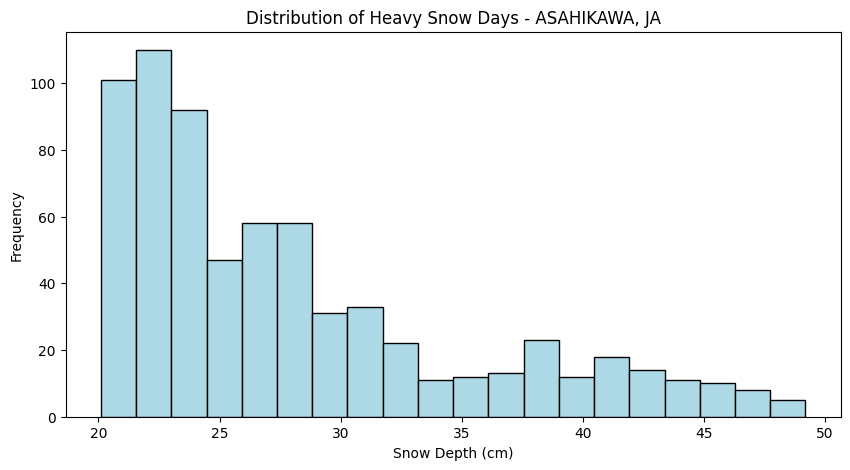

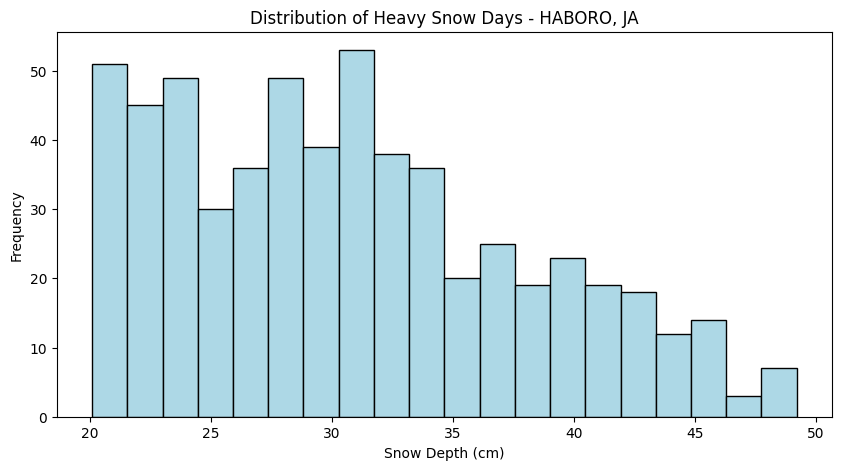

In [29]:
for station_name, g in heavy_snow.groupby("NAME"):
    plt.figure(figsize=(10,5))
    plt.hist(g["SNWD"], bins=20, color="lightblue", edgecolor="black")
    plt.title(f"Distribution of Heavy Snow Days - {station_name}")
    plt.xlabel("Snow Depth (cm)")
    plt.ylabel("Frequency")
    plt.show()


In [30]:
max_snow_value = japan_snow_clean["SNWD"].max()
max_snow_row = japan_snow_clean[japan_snow_clean["SNWD"] == max_snow_value]

print(f"Maximum daily snow depth: {max_snow_value} cm")
print(max_snow_row)


Maximum daily snow depth: 49.2 cm
            DATE      STATION           NAME  LATITUDE  LONGITUDE  ELEVATION  \
1852  1995-01-27  JA000047404     HABORO, JA    44.367    141.700       10.0   
1853  1995-01-28  JA000047404     HABORO, JA    44.367    141.700       10.0   
1855  1995-01-30  JA000047404     HABORO, JA    44.367    141.700       10.0   
1859  1995-02-03  JA000047404     HABORO, JA    44.367    141.700       10.0   
1860  1995-02-04  JA000047404     HABORO, JA    44.367    141.700       10.0   
16353 1999-03-12  JA000047407  ASAHIKAWA, JA    43.767    142.367      116.0   
42319 1999-02-14  JA000047575     AOMORI, JA    40.817    140.767        3.0   

       SNWD  Month  
1852   49.2      1  
1853   49.2      1  
1855   49.2      1  
1859   49.2      2  
1860   49.2      2  
16353  49.2      3  
42319  49.2      2  


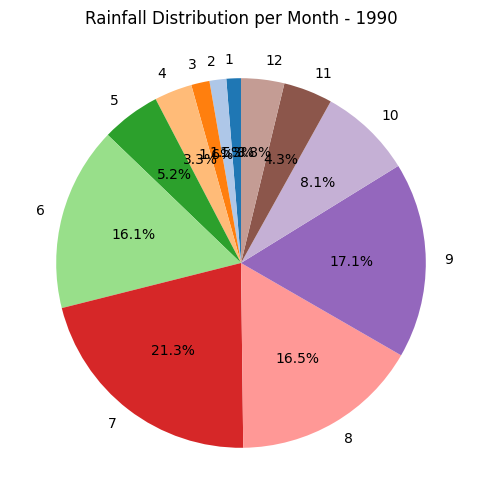

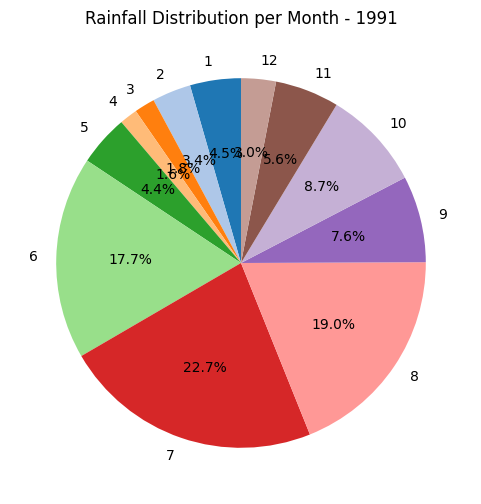

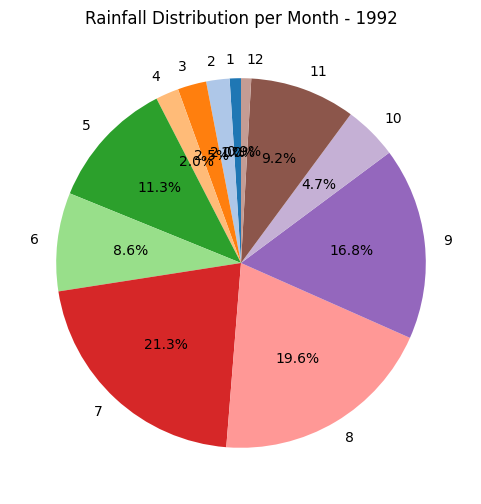

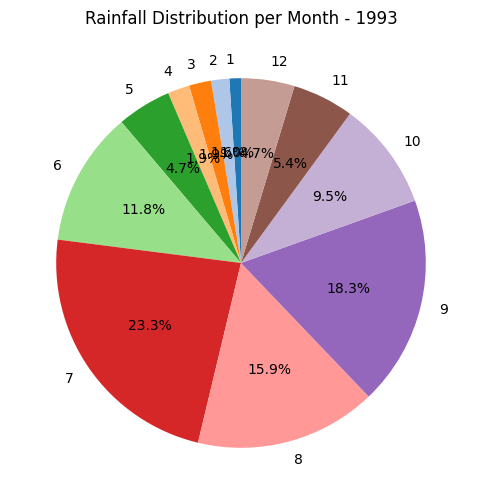

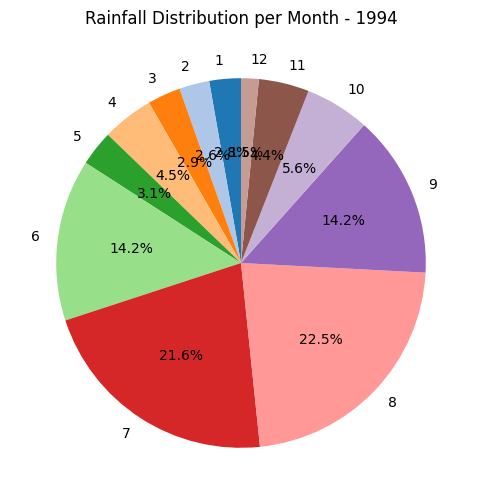

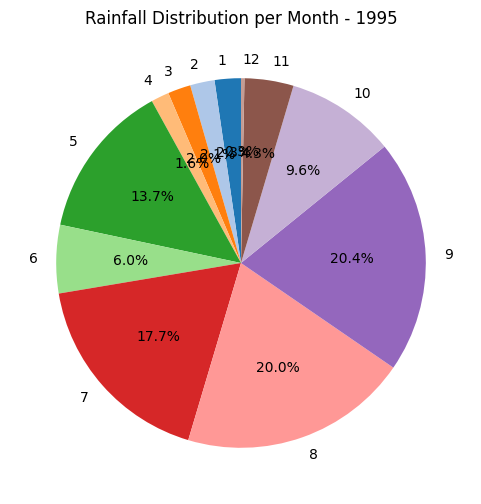

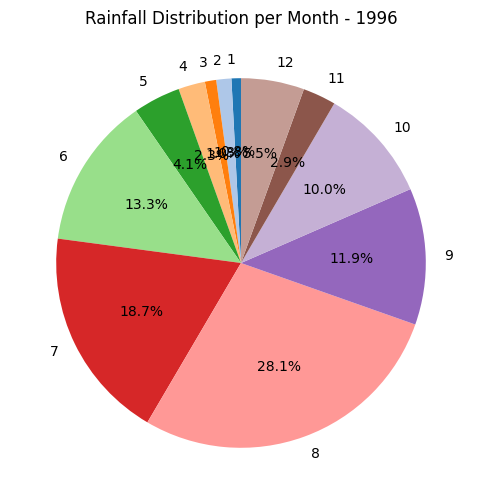

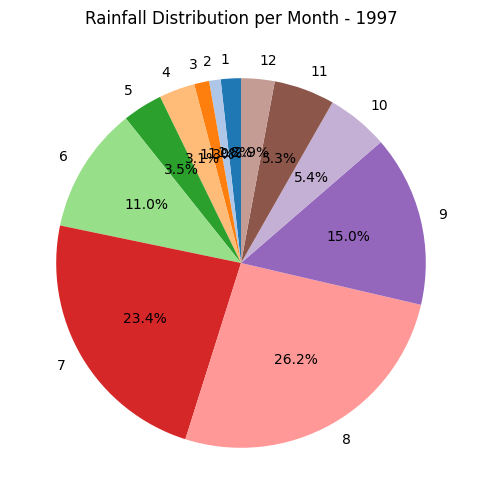

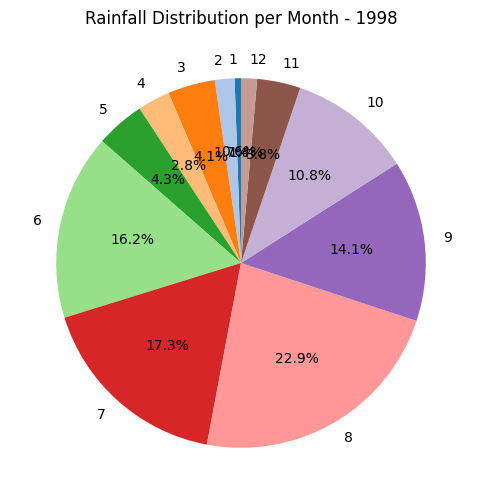

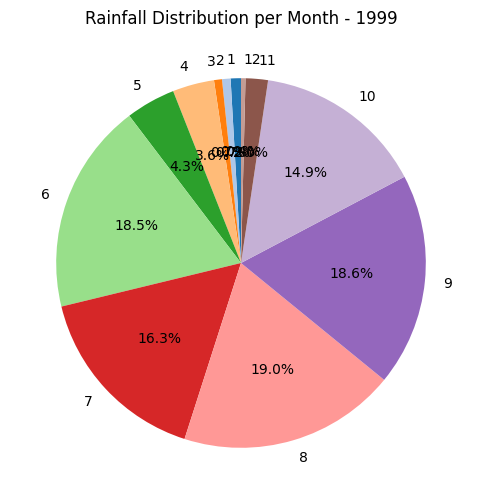

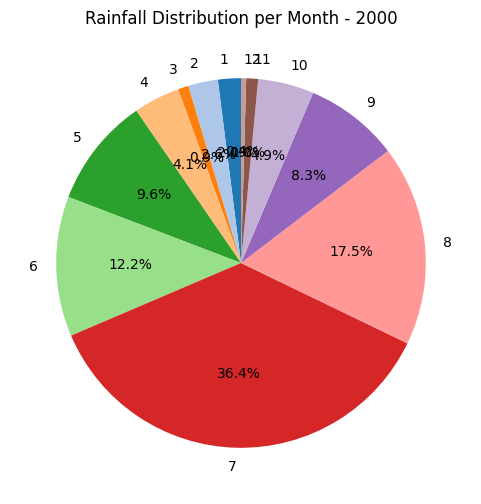

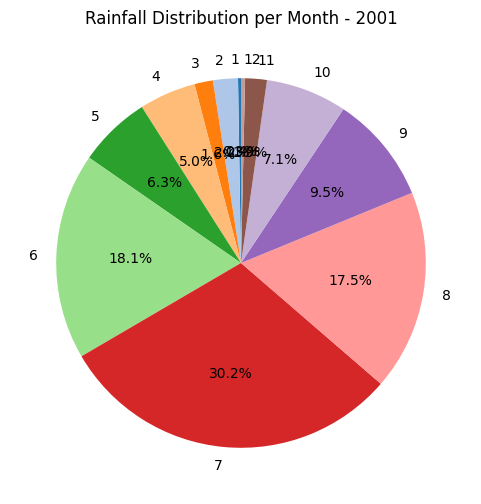

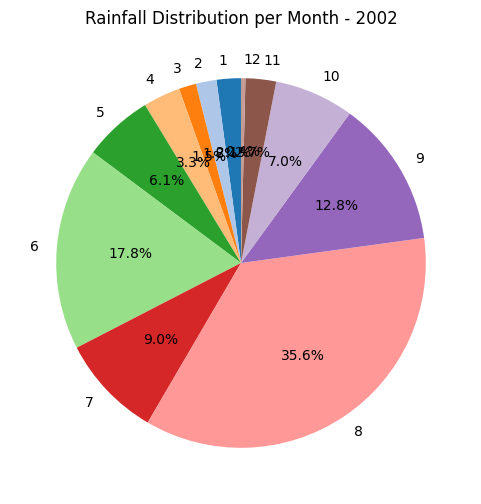

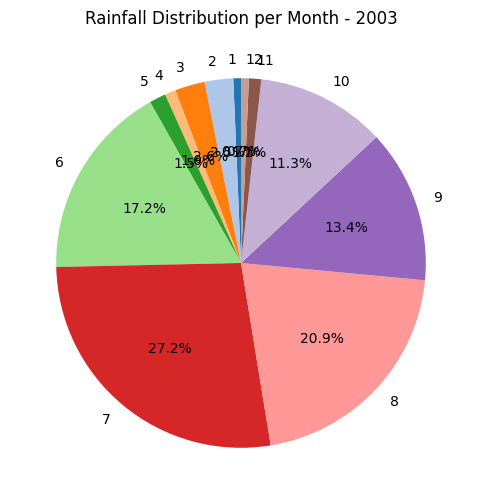

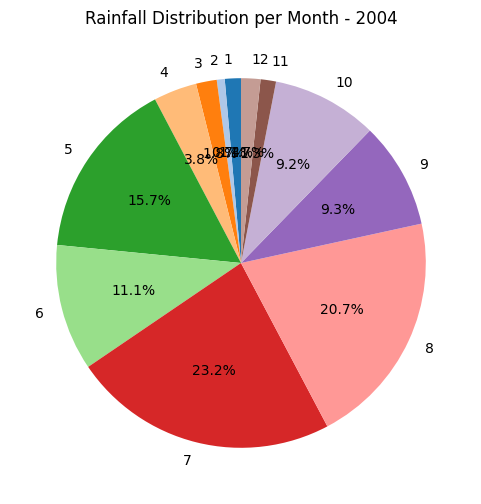

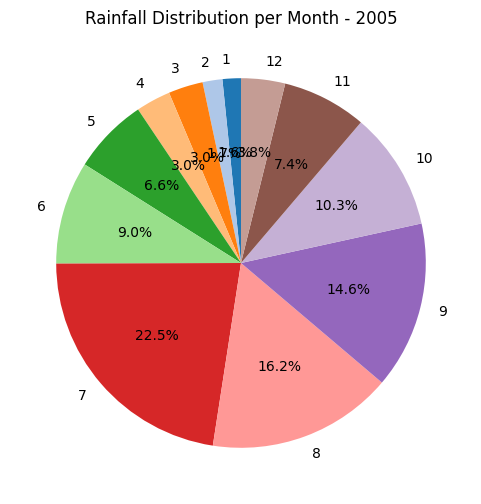

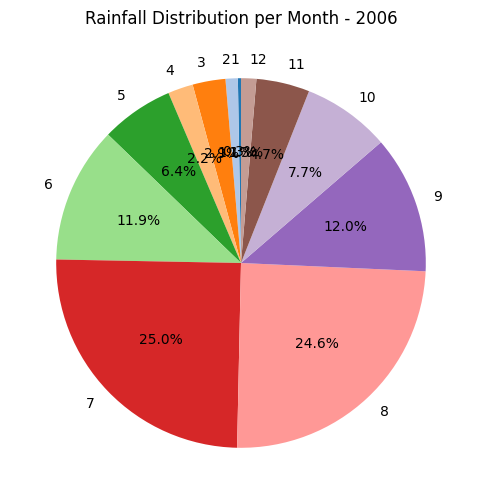

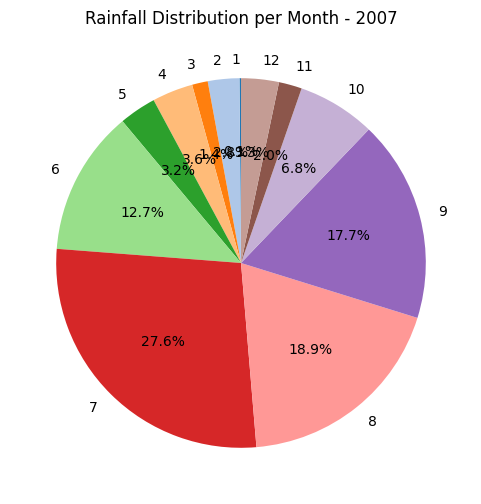

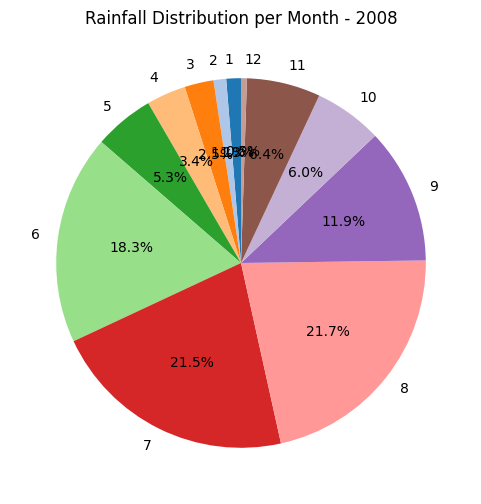

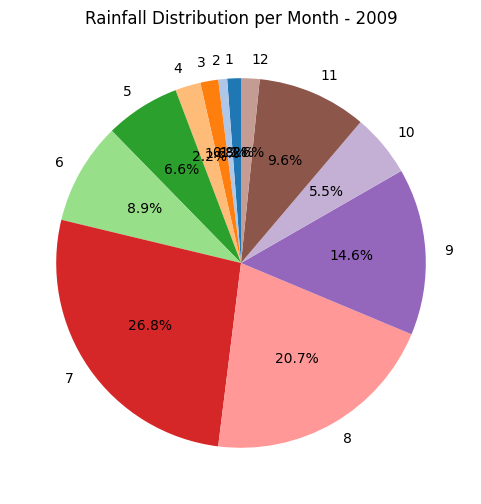

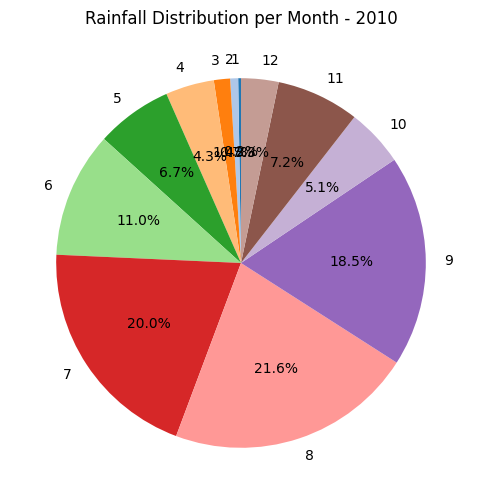

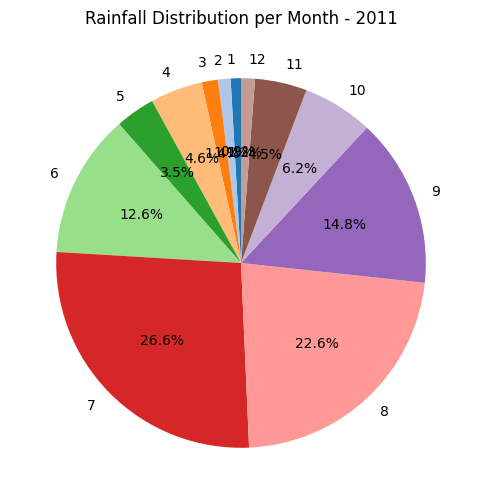

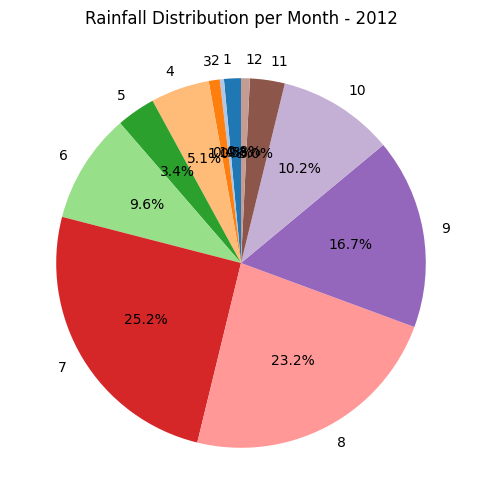

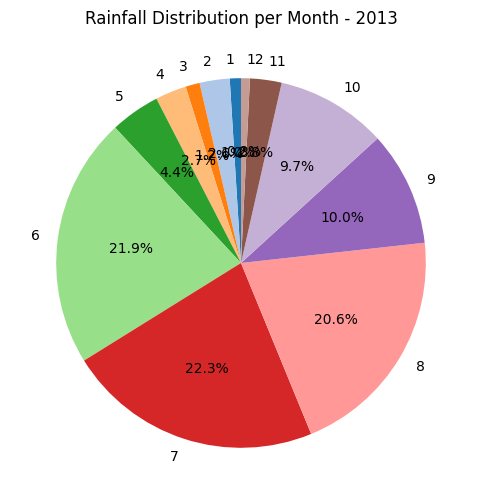

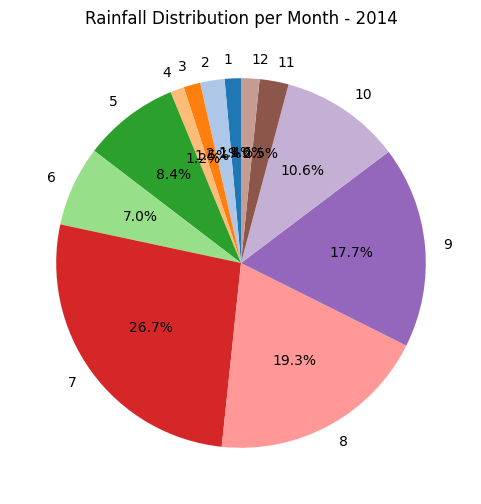

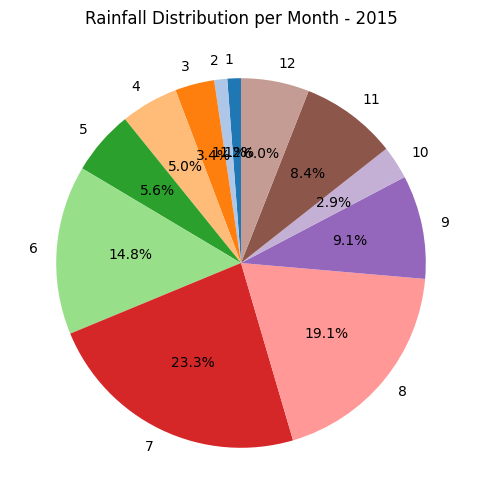

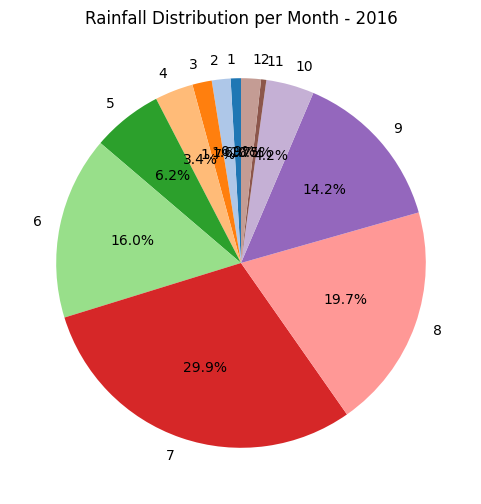

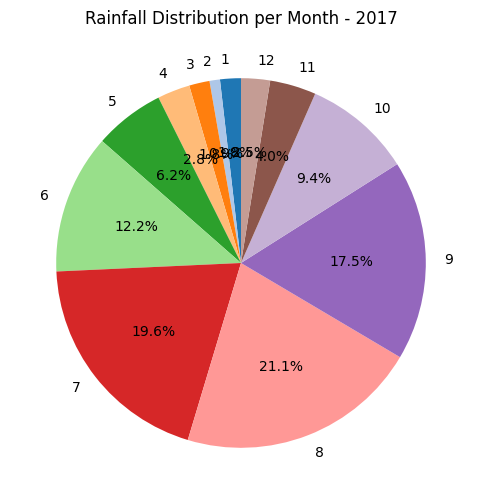

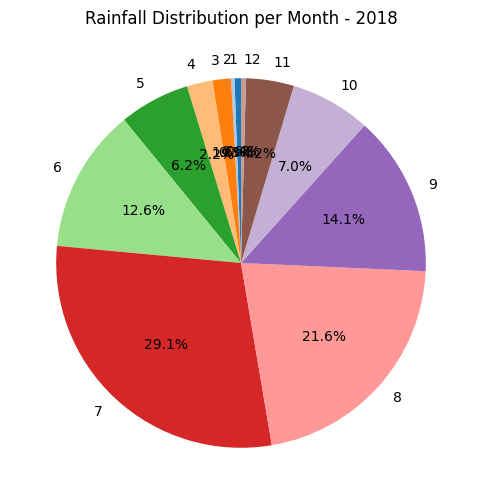

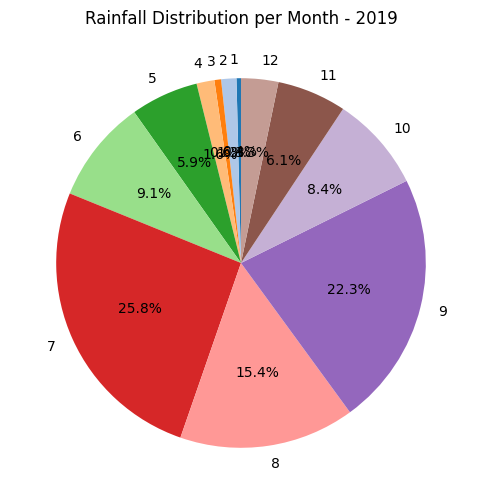

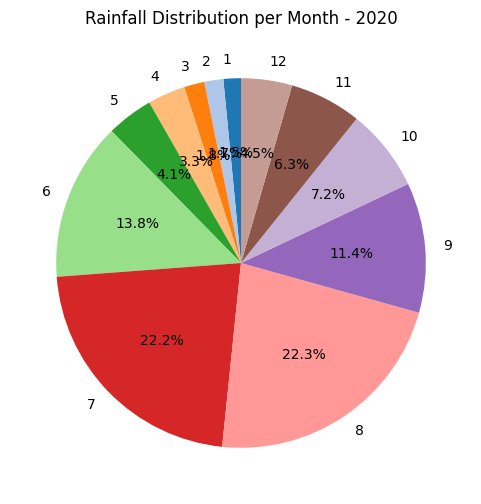

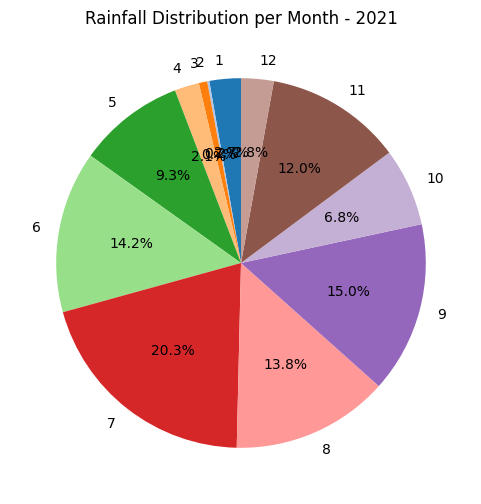

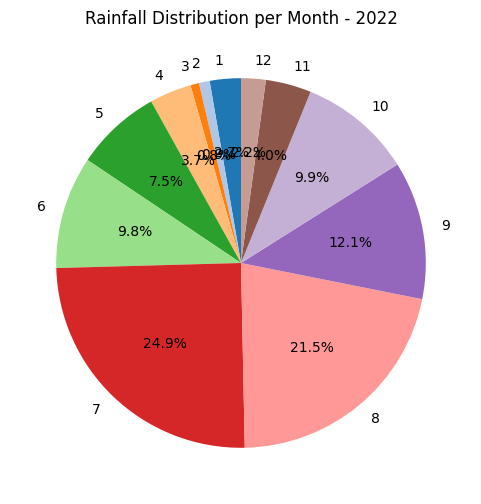

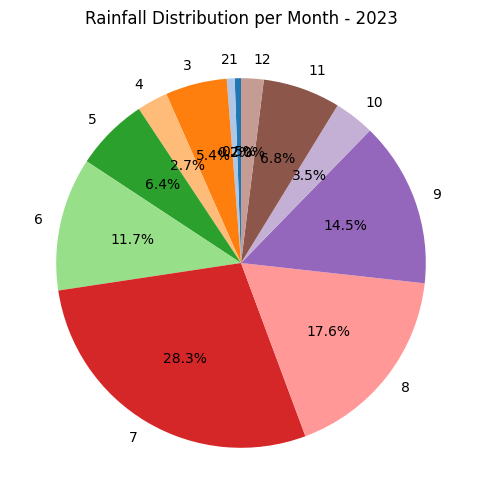

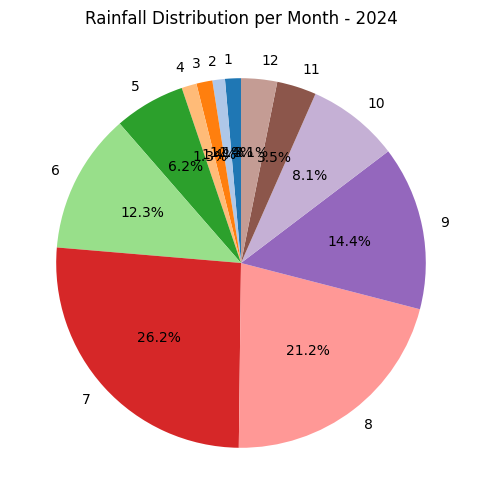

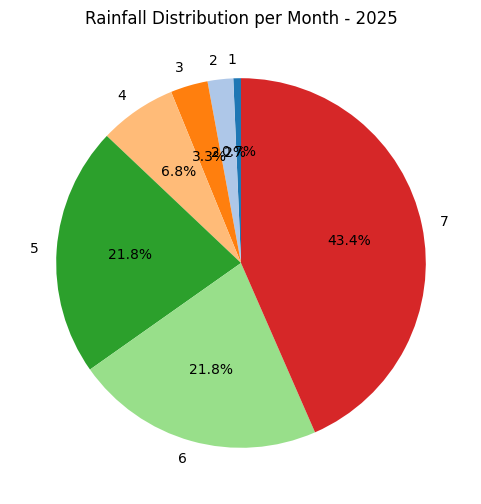

In [31]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Add Year and Month columns
india_rainfall_clean["Year"] = india_rainfall_clean["DATE"].dt.year
india_rainfall_clean["Month"] = india_rainfall_clean["DATE"].dt.month

# Choose a color map with 12 distinct colors for the months
colors = cm.tab20(np.arange(12))  # tab20 is colorful and distinguishable

# Loop through each year
for year, g in india_rainfall_clean.groupby("Year"):
    monthly_total = g.groupby("Month")["PRCP"].sum()

    plt.figure(figsize=(6,6))
    plt.pie(
        monthly_total,
        labels=[f"{m}" for m in monthly_total.index],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors
    )
    plt.title(f"Rainfall Distribution per Month - {year}")
    plt.show()


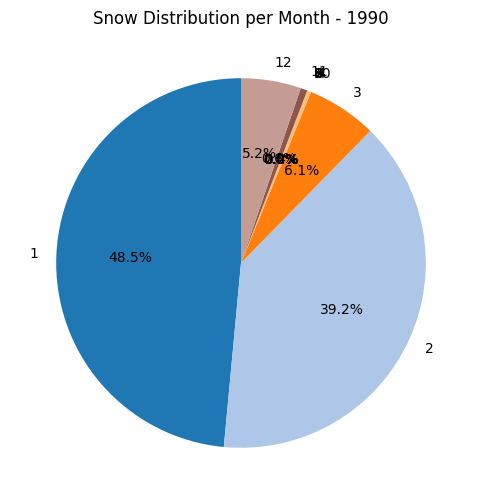

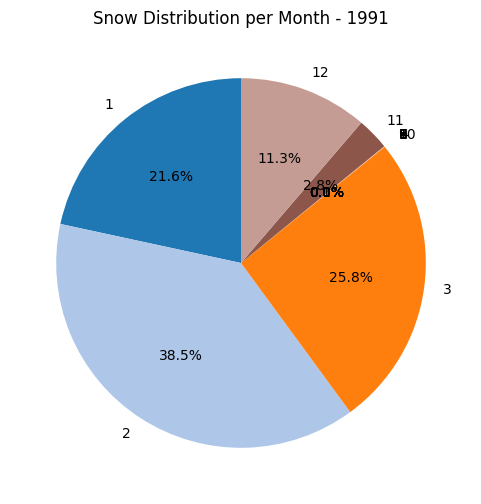

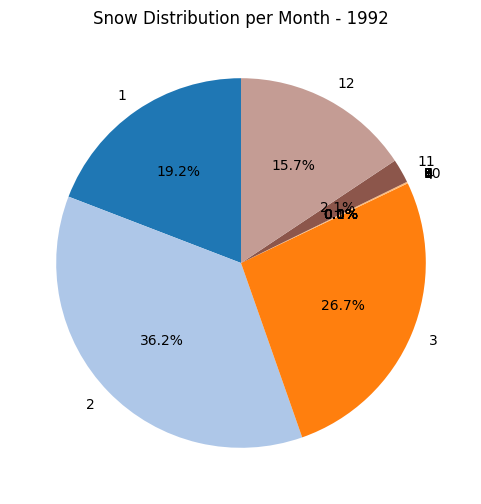

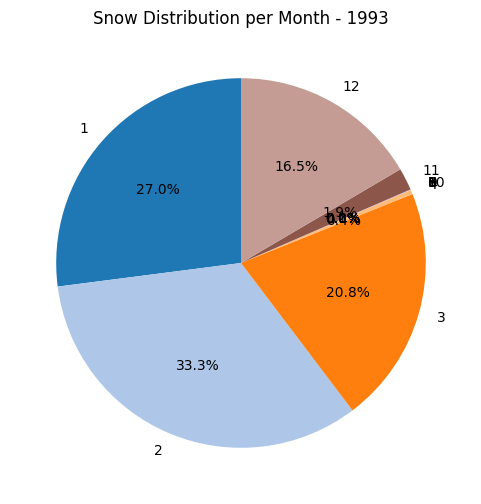

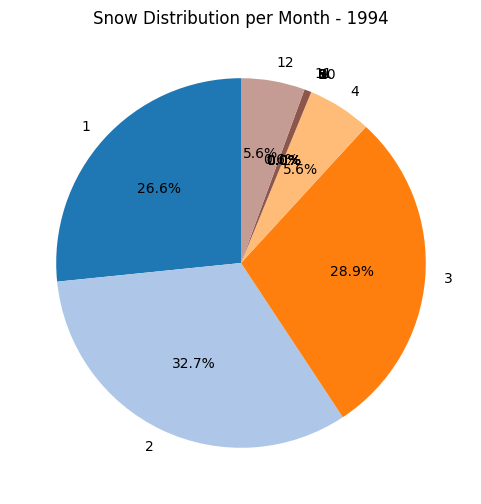

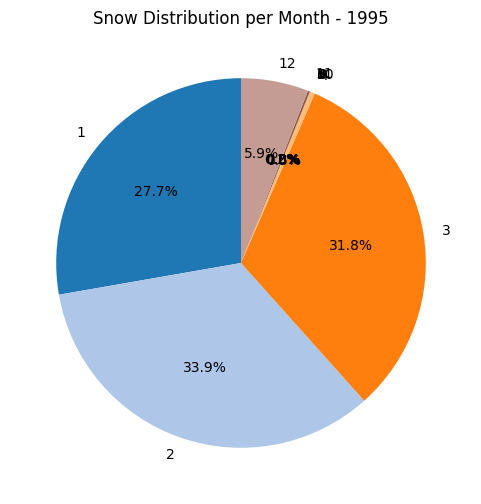

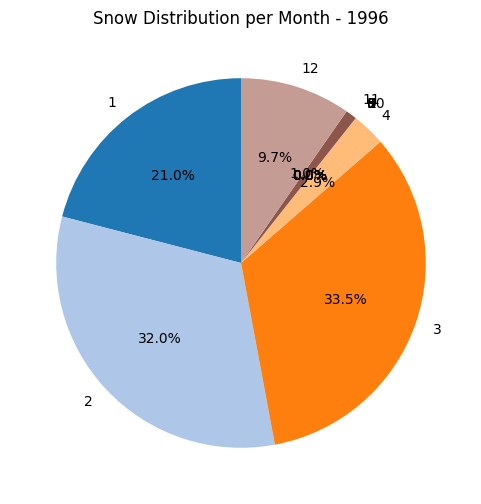

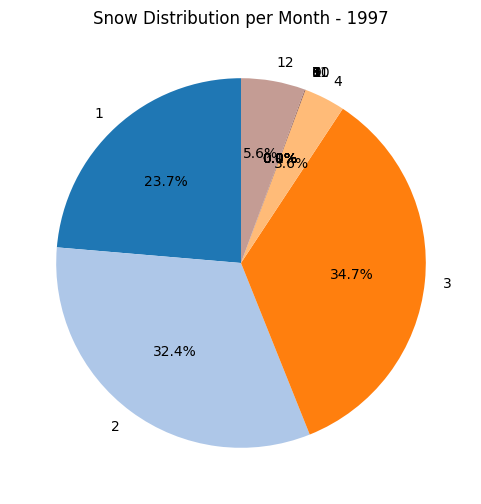

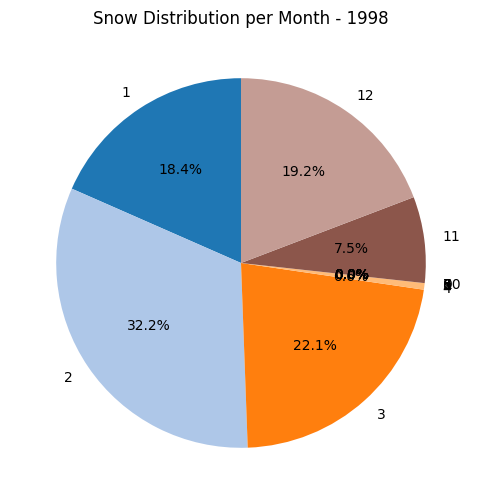

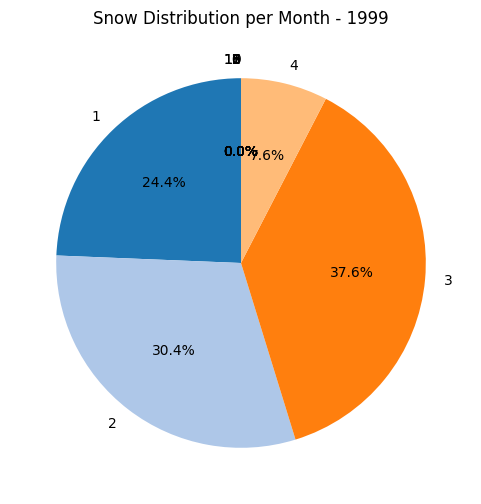

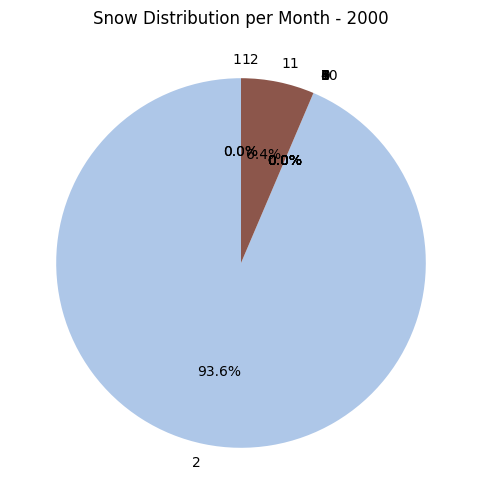

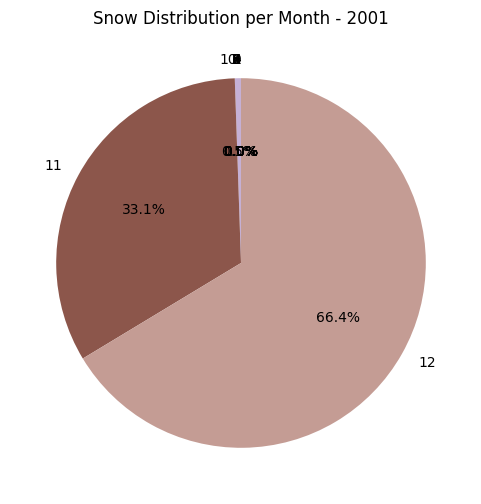

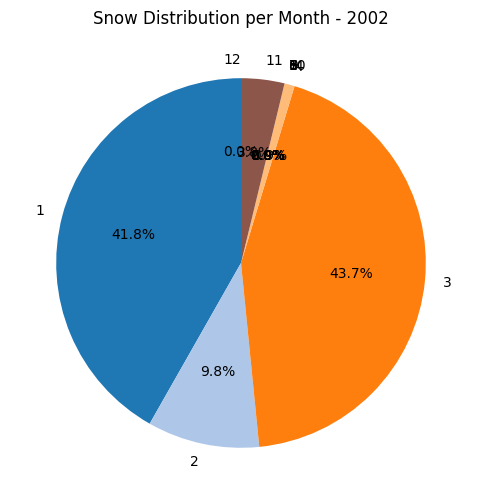

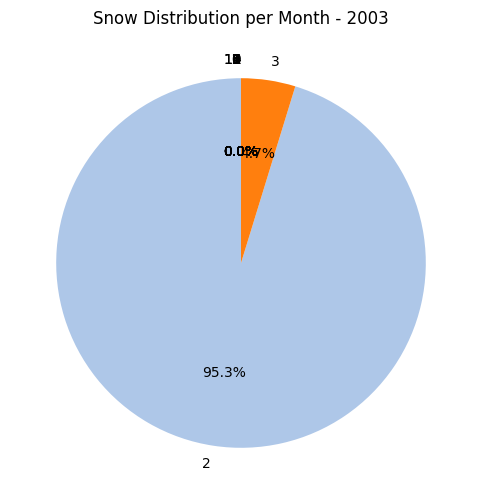

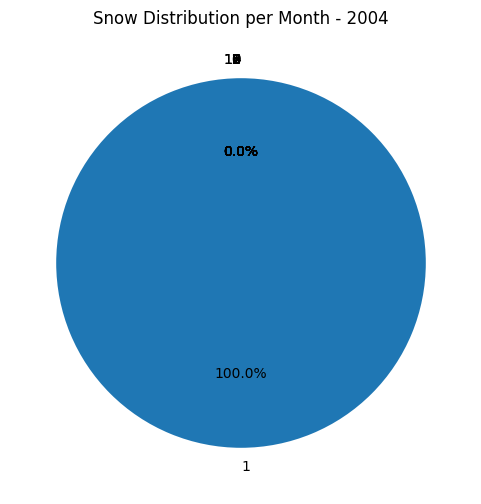

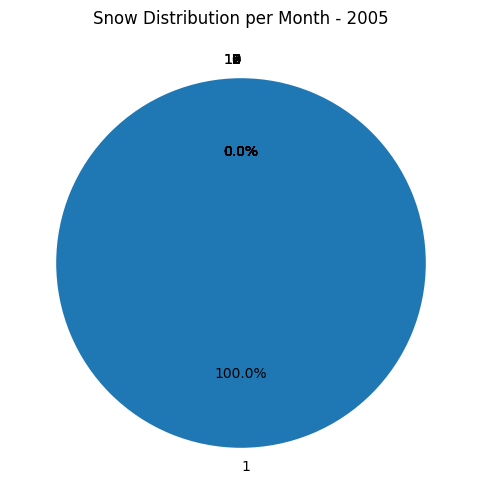

ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 600x600 with 1 Axes>

In [33]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Add Year and Month columns
japan_snow_clean["Year"] = japan_snow_clean["DATE"].dt.year
japan_snow_clean["Month"] = japan_snow_clean["DATE"].dt.month

# Choose a color map with 12 distinct colors for the months
colors = cm.tab20(np.arange(12))  # tab20 is colorful and distinguishable

# Loop through each year
for year, g in japan_snow_clean.groupby("Year"):
    monthly_total = g.groupby("Month")["SNWD"].sum()

    plt.figure(figsize=(6,6))
    plt.pie(
        monthly_total,
        labels=[f"{m}" for m in monthly_total.index],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors
    )
    plt.title(f"Snow Distribution per Month - {year}")
    plt.show()


#DATA MODELING

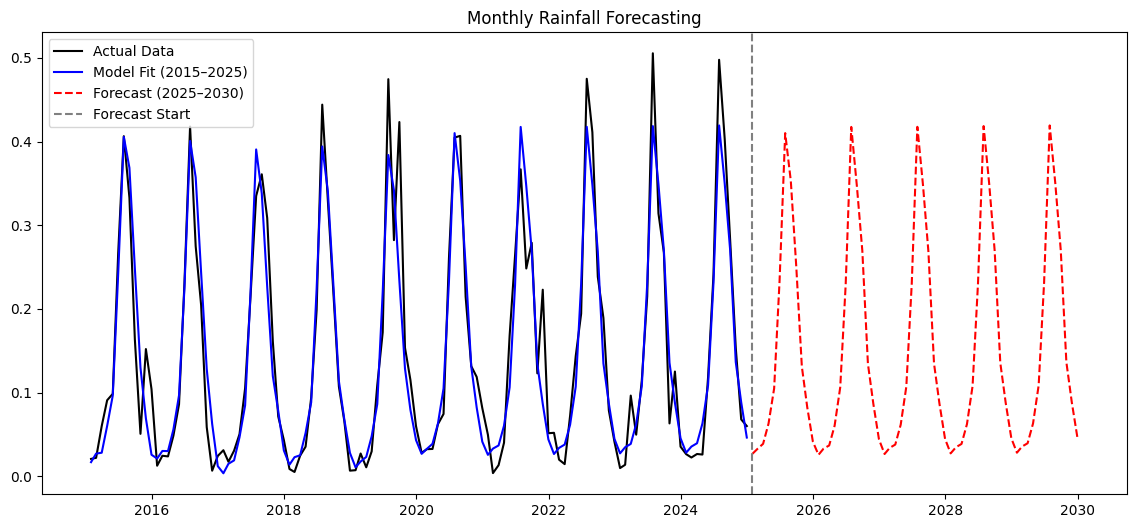

Forecasted monthly values (2025–2030):
2025-01-31    0.026770
2025-02-28    0.032685
2025-03-31    0.038732
2025-04-30    0.062884
2025-05-31    0.104946
2025-06-30    0.233705
2025-07-31    0.410043
2025-08-31    0.353010
2025-09-30    0.251230
2025-10-31    0.131079
2025-11-30    0.082149
2025-12-31    0.041251
Freq: ME, dtype: float64

Model Accuracy:
Train (1990–2019):
  RMSE: 0.06
  MAE : 0.04

Test (2020–2024):
  RMSE: 0.04
  MAE : 0.03


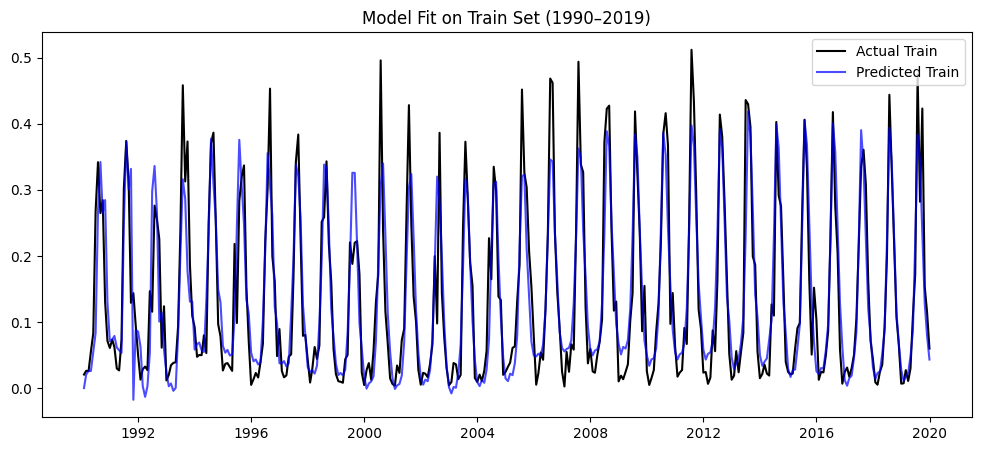

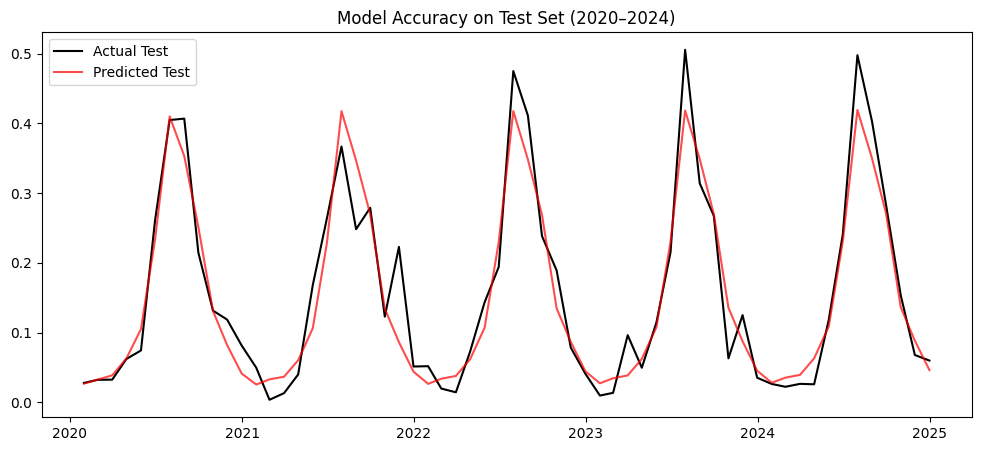

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ================================
# LOAD DATA
# ================================
df = pd.read_csv("India_Rainfall_Clean.csv", parse_dates=["DATE"])
df = df.groupby("DATE")["PRCP"].mean().reset_index()
df = df.set_index("DATE")

# Aggregate to monthly mean (lighter than daily)
df_monthly = df.resample("ME").mean()   # 'ME' = month end

# ================================
# TRAIN/TEST SPLIT
# ================================
train = df_monthly[:'2019-12-31']   # 30 years (1990–2019)
test = df_monthly['2020-01-01':'2024-12-31']   # 5 years (2020–2024)

# ================================
# FIT MODEL
# ================================
# Use seasonal period = 12 (monthly seasonality)
model1 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12),
                enforce_stationarity=False, enforce_invertibility=False)
results = model1.fit(disp=False)

# ================================
# IN-SAMPLE FORECAST (2015–2025)
# ================================
in_sample_forecast = results.get_prediction(
    start=pd.to_datetime("2015-01-31"),
    end=pd.to_datetime("2024-12-31")
)
in_sample_mean = in_sample_forecast.predicted_mean

# ================================
# OUT-OF-SAMPLE FORECAST (2025–2030)
# ================================
future_forecast = results.get_forecast(steps=5*12)  # 5 years monthly
future_index = pd.date_range(start="2025-01-31", periods=5*12, freq="ME")
future_mean = pd.Series(future_forecast.predicted_mean.values, index=future_index)

# ================================
# PLOT
# ================================
plt.figure(figsize=(14,6))
# Show actual last 10 years
plt.plot(df_monthly['2015-01-01':'2024-12-31'], label="Actual Data", color="black")
# In-sample forecast overlap
plt.plot(in_sample_mean, label="Model Fit (2015–2025)", color="blue")
# Out-of-sample forecast
plt.plot(future_mean, label="Forecast (2025–2030)", color="red", linestyle="--")

# Vertical line marking forecast start
plt.axvline(x=pd.to_datetime("2025-01-31"), color="gray", linestyle="--", label="Forecast Start")

plt.legend()
plt.title("Monthly Rainfall Forecasting")
plt.show()

# ================================
# PRINT FORECAST VALUES 2025–2030
# ================================
print("Forecasted monthly values (2025–2030):")
print(future_mean.head(12))  # first 12 months of 2025

# #######################################################################################################

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ================================
# TRAIN PREDICTIONS (1990–2019)
# ================================
train_forecast = results.get_prediction(
    start=train.index.min(),
    end=train.index.max()
)
train_pred = train_forecast.predicted_mean

# Align indexes
train_aligned = train.reindex(train_pred.index)

# Train accuracy
train_rmse = np.sqrt(mean_squared_error(train_aligned, train_pred))
train_mae = mean_absolute_error(train_aligned, train_pred)
train_mape = np.mean(np.abs((train_aligned - train_pred) / train_aligned)) * 100

# ================================
# TEST PREDICTIONS (2020–2024)
# ================================
test_forecast = results.get_prediction(
    start=test.index.min(),
    end=test.index.max()
)
test_pred = test_forecast.predicted_mean

# Align indexes
test_aligned = test.reindex(test_pred.index)

# Test accuracy
test_rmse = np.sqrt(mean_squared_error(test_aligned, test_pred))
test_mae = mean_absolute_error(test_aligned, test_pred)

# ================================
# PRINT RESULTS
# ================================
print("\nModel Accuracy:")
print("Train (1990–2019):")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE : {train_mae:.2f}")

print("\nTest (2020–2024):")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAE : {test_mae:.2f}")

# ================================
# OPTIONAL: PLOTS
# ================================
plt.figure(figsize=(12,5))
plt.plot(train_aligned, label="Actual Train", color="black")
plt.plot(train_pred, label="Predicted Train", color="blue", alpha=0.7)
plt.title("Model Fit on Train Set (1990–2019)")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(test_aligned, label="Actual Test", color="black")
plt.plot(test_pred, label="Predicted Test", color="red", alpha=0.7)
plt.title("Model Accuracy on Test Set (2020–2024)")
plt.legend()
plt.show()


In [35]:
import joblib

# Save the fitted ARIMA model
joblib.dump(model1, "india_rain_sarima_model.pkl")

# If you want to download it to your local machine from Colab
from google.colab import files
files.download("india_rain_sarima_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

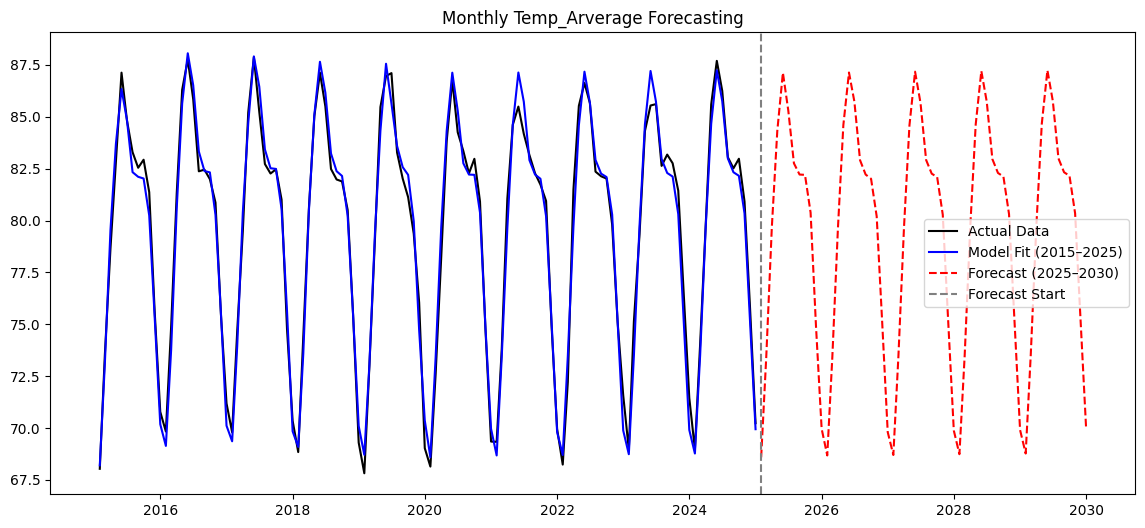

Forecasted monthly values (2025–2030):
2025-01-31    68.587798
2025-02-28    73.406814
2025-03-31    79.694797
2025-04-30    84.311882
2025-05-31    87.123634
2025-06-30    85.286951
2025-07-31    82.756262
2025-08-31    82.215915
2025-09-30    82.200770
2025-10-31    80.381856
2025-11-30    74.872541
2025-12-31    69.965051
Freq: ME, dtype: float64


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ================================
# LOAD DATA
# ================================
df = pd.read_csv("India_Temp_Clean.csv", parse_dates=["DATE"])
df = df.groupby("DATE")["TAVG"].mean().reset_index()
df = df.set_index("DATE")

# Aggregate to monthly mean (lighter than daily)
df_monthly = df.resample("ME").mean()   # 'ME' = month end

# ================================
# TRAIN/TEST SPLIT
# ================================
train = df_monthly[:'2019-12-31']   # 30 years (1990–2019)
test = df_monthly['2020-01-01':'2024-12-31']   # 5 years (2020–2024)

# ================================
# FIT MODEL
# ================================
# Use seasonal period = 12 (monthly seasonality)
model2 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12),
                enforce_stationarity=False, enforce_invertibility=False)
results = model2.fit(disp=False)

# ================================
# IN-SAMPLE FORECAST (2015–2025)
# ================================
in_sample_forecast = results.get_prediction(
    start=pd.to_datetime("2015-01-31"),
    end=pd.to_datetime("2024-12-31")
)
in_sample_mean = in_sample_forecast.predicted_mean

# ================================
# OUT-OF-SAMPLE FORECAST (2025–2030)
# ================================
future_forecast = results.get_forecast(steps=5*12)  # 5 years monthly
future_index = pd.date_range(start="2025-01-31", periods=5*12, freq="ME")
future_mean = pd.Series(future_forecast.predicted_mean.values, index=future_index)

# ================================
# PLOT
# ================================
plt.figure(figsize=(14,6))
# Show actual last 10 years
plt.plot(df_monthly['2015-01-01':'2024-12-31'], label="Actual Data", color="black")
# In-sample forecast overlap
plt.plot(in_sample_mean, label="Model Fit (2015–2025)", color="blue")
# Out-of-sample forecast
plt.plot(future_mean, label="Forecast (2025–2030)", color="red", linestyle="--")

# Vertical line marking forecast start
plt.axvline(x=pd.to_datetime("2025-01-31"), color="gray", linestyle="--", label="Forecast Start")

plt.legend()
plt.title("Monthly Temp_Arverage Forecasting")
plt.show()

# ================================
# PRINT FORECAST VALUES 2025–2030
# ================================
print("Forecasted monthly values (2025–2030):")
print(future_mean.head(12))  # first 12 months of 2025


In [37]:
import joblib

# Save the fitted ARIMA model
joblib.dump(model2, "india_temp_avg_sarima_model.pkl")

# If you want to download it to your local machine from Colab
from google.colab import files
files.download("india_temp_avg_sarima_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

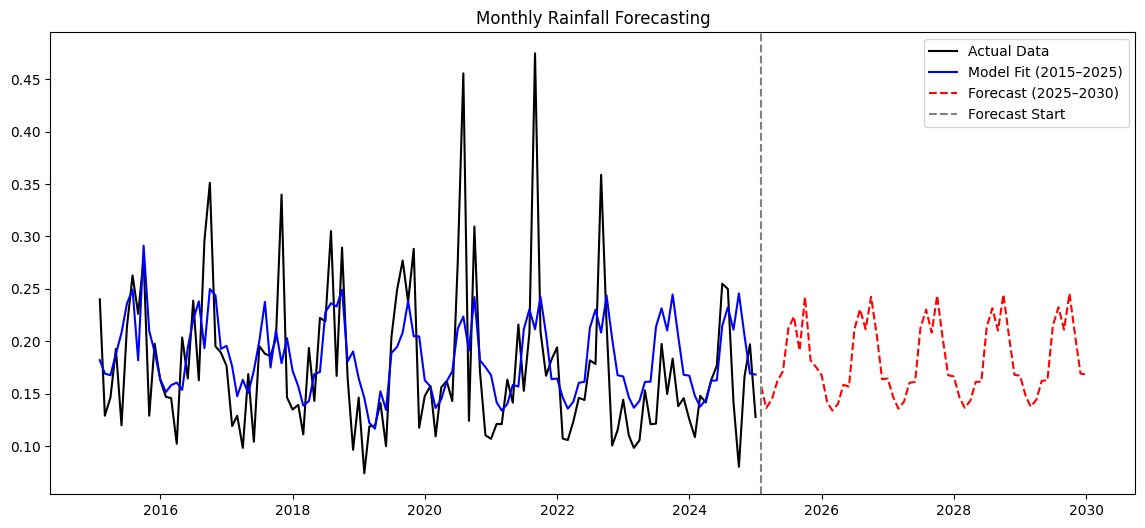

Forecasted monthly values (2025–2030):
2025-01-31    0.156827
2025-02-28    0.136267
2025-03-31    0.144451
2025-04-30    0.161643
2025-05-31    0.171334
2025-06-30    0.211891
2025-07-31    0.223490
2025-08-31    0.191139
2025-09-30    0.242173
2025-10-31    0.181670
2025-11-30    0.175323
2025-12-31    0.167541
Freq: ME, dtype: float64


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ================================
# LOAD DATA
# ================================
df = pd.read_csv("Japan_Rainfall_Clean.csv", parse_dates=["DATE"])
df = df.groupby("DATE")["PRCP"].mean().reset_index()
df = df.set_index("DATE")

# Aggregate to monthly mean (lighter than daily)
df_monthly = df.resample("ME").mean()   # 'ME' = month end

# ================================
# TRAIN/TEST SPLIT
# ================================
train = df_monthly[:'2019-12-31']   # 30 years (1990–2019)
test = df_monthly['2020-01-01':'2024-12-31']   # 5 years (2020–2024)

# ================================
# FIT MODEL
# ================================
# Use seasonal period = 12 (monthly seasonality)
model3 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12),
                enforce_stationarity=False, enforce_invertibility=False)
results = model3.fit(disp=False)

# ================================
# IN-SAMPLE FORECAST (2015–2025)
# ================================
in_sample_forecast = results.get_prediction(
    start=pd.to_datetime("2015-01-31"),
    end=pd.to_datetime("2024-12-31")
)
in_sample_mean = in_sample_forecast.predicted_mean

# ================================
# OUT-OF-SAMPLE FORECAST (2025–2030)
# ================================
future_forecast = results.get_forecast(steps=5*12)  # 5 years monthly
future_index = pd.date_range(start="2025-01-31", periods=5*12, freq="ME")
future_mean = pd.Series(future_forecast.predicted_mean.values, index=future_index)

# ================================
# PLOT
# ================================
plt.figure(figsize=(14,6))
# Show actual last 10 years
plt.plot(df_monthly['2015-01-01':'2024-12-31'], label="Actual Data", color="black")
# In-sample forecast overlap
plt.plot(in_sample_mean, label="Model Fit (2015–2025)", color="blue")
# Out-of-sample forecast
plt.plot(future_mean, label="Forecast (2025–2030)", color="red", linestyle="--")

# Vertical line marking forecast start
plt.axvline(x=pd.to_datetime("2025-01-31"), color="gray", linestyle="--", label="Forecast Start")

plt.legend()
plt.title("Monthly Rainfall Forecasting")
plt.show()

# ================================
# PRINT FORECAST VALUES 2025–2030
# ================================
print("Forecasted monthly values (2025–2030):")
print(future_mean.head(12))  # first 12 months of 2025


In [39]:
import joblib

# Save the fitted ARIMA model
joblib.dump(model3, "japan_rainfall_sarima_model.pkl")

# If you want to download it to your local machine from Colab
from google.colab import files
files.download("japan_rainfall_sarima_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

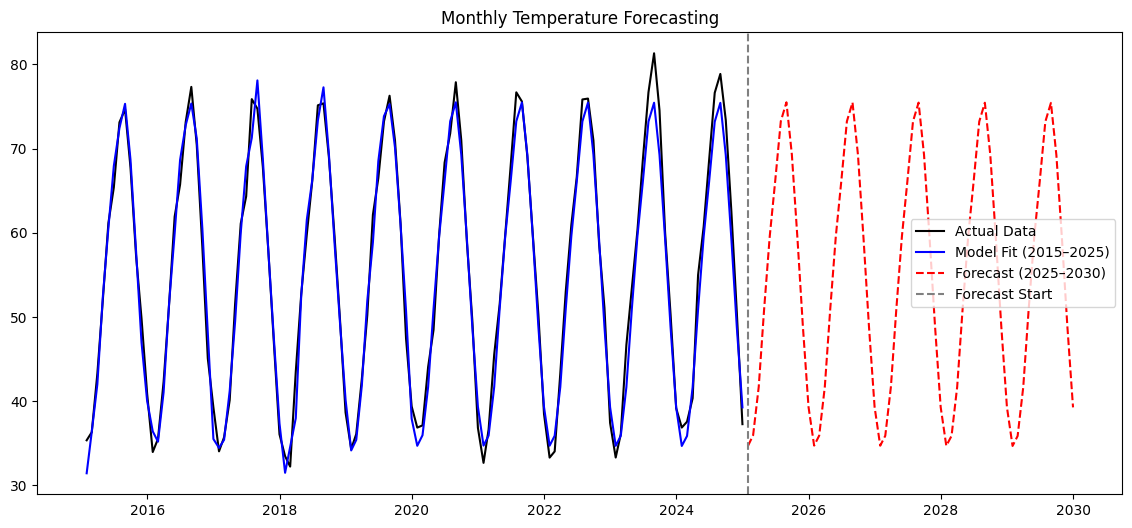

Forecasted monthly values (2025–2030):
2025-01-31    34.709245
2025-02-28    35.961887
2025-03-31    41.700441
2025-04-30    50.981692
2025-05-31    59.620264
2025-06-30    66.140887
2025-07-31    73.243899
2025-08-31    75.497437
2025-09-30    69.290837
2025-10-31    59.302925
2025-11-30    48.852772
2025-12-31    39.331468
Freq: ME, dtype: float64


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ================================
# LOAD DATA
# ================================
df = pd.read_csv("Japan_Temp_Clean.csv", parse_dates=["DATE"])
df = df.groupby("DATE")["TAVG"].mean().reset_index()
df = df.set_index("DATE")

# Aggregate to monthly mean (lighter than daily)
df_monthly = df.resample("ME").mean()   # 'ME' = month end

# ================================
# TRAIN/TEST SPLIT
# ================================
train = df_monthly[:'2019-12-31']   # 30 years (1990–2019)
test = df_monthly['2020-01-01':'2024-12-31']   # 5 years (2020–2024)

# ================================
# FIT MODEL
# ================================
# Use seasonal period = 12 (monthly seasonality)
model4 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12),
                enforce_stationarity=False, enforce_invertibility=False)
results = model4.fit(disp=False)

# ================================
# IN-SAMPLE FORECAST (2015–2025)
# ================================
in_sample_forecast = results.get_prediction(
    start=pd.to_datetime("2015-01-31"),
    end=pd.to_datetime("2024-12-31")
)
in_sample_mean = in_sample_forecast.predicted_mean

# ================================
# OUT-OF-SAMPLE FORECAST (2025–2030)
# ================================
future_forecast = results.get_forecast(steps=5*12)  # 5 years monthly
future_index = pd.date_range(start="2025-01-31", periods=5*12, freq="ME")
future_mean = pd.Series(future_forecast.predicted_mean.values, index=future_index)

# ================================
# PLOT
# ================================
plt.figure(figsize=(14,6))
# Show actual last 10 years
plt.plot(df_monthly['2015-01-01':'2024-12-31'], label="Actual Data", color="black")
# In-sample forecast overlap
plt.plot(in_sample_mean, label="Model Fit (2015–2025)", color="blue")
# Out-of-sample forecast
plt.plot(future_mean, label="Forecast (2025–2030)", color="red", linestyle="--")

# Vertical line marking forecast start
plt.axvline(x=pd.to_datetime("2025-01-31"), color="gray", linestyle="--", label="Forecast Start")

plt.legend()
plt.title("Monthly Temperature Forecasting")
plt.show()

# ================================
# PRINT FORECAST VALUES 2025–2030
# ================================
print("Forecasted monthly values (2025–2030):")
print(future_mean.head(12))  # first 12 months of 2025


In [41]:
import joblib

# Save the fitted ARIMA model
joblib.dump(model4, "japan_temp_avg_sarima_model.pkl")

# If you want to download it to your local machine from Colab
from google.colab import files
files.download("japan_temp_avg_sarima_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

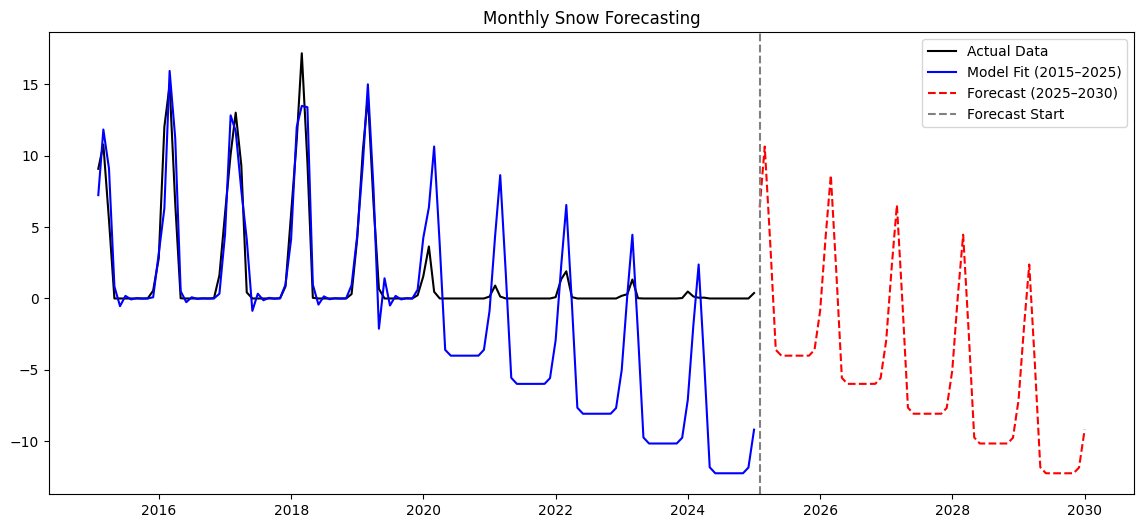

Forecasted monthly values (2025–2030):
2025-01-31     6.372999
2025-02-28    10.634444
2025-03-31     3.731287
2025-04-30    -3.594929
2025-05-31    -4.002242
2025-06-30    -4.002242
2025-07-31    -4.002242
2025-08-31    -4.002242
2025-09-30    -4.002242
2025-10-31    -3.999863
2025-11-30    -3.590539
2025-12-31    -0.861970
Freq: ME, dtype: float64


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ================================
# LOAD DATA
# ================================
df = pd.read_csv("Japan_Snow_Clean.csv", parse_dates=["DATE"])
df = df.groupby("DATE")["SNWD"].mean().reset_index()
df = df.set_index("DATE")

# Aggregate to monthly mean (lighter than daily)
df_monthly = df.resample("ME").mean()   # 'ME' = month end

# ================================
# TRAIN/TEST SPLIT
# ================================
train = df_monthly[:'2019-12-31']   # 30 years (1990–2019)
test = df_monthly['2020-01-01':'2024-12-31']   # 5 years (2020–2024)

# ================================
# FIT MODEL
# ================================
# Use seasonal period = 12 (monthly seasonality)
model5 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12),
                enforce_stationarity=False, enforce_invertibility=False)
results = model5.fit(disp=False)

# ================================
# IN-SAMPLE FORECAST (2015–2025)
# ================================
in_sample_forecast = results.get_prediction(
    start=pd.to_datetime("2015-01-31"),
    end=pd.to_datetime("2024-12-31")
)
in_sample_mean = in_sample_forecast.predicted_mean

# ================================
# OUT-OF-SAMPLE FORECAST (2025–2030)
# ================================
future_forecast = results.get_forecast(steps=5*12)  # 5 years monthly
future_index = pd.date_range(start="2025-01-31", periods=5*12, freq="ME")
future_mean = pd.Series(future_forecast.predicted_mean.values, index=future_index)

# ================================
# PLOT
# ================================
plt.figure(figsize=(14,6))
# Show actual last 10 years
plt.plot(df_monthly['2015-01-01':'2024-12-31'], label="Actual Data", color="black")
# In-sample forecast overlap
plt.plot(in_sample_mean, label="Model Fit (2015–2025)", color="blue")
# Out-of-sample forecast
plt.plot(future_mean, label="Forecast (2025–2030)", color="red", linestyle="--")

# Vertical line marking forecast start
plt.axvline(x=pd.to_datetime("2025-01-31"), color="gray", linestyle="--", label="Forecast Start")

plt.legend()
plt.title("Monthly Snow Forecasting")
plt.show()

# ================================
# PRINT FORECAST VALUES 2025–2030
# ================================
print("Forecasted monthly values (2025–2030):")
print(future_mean.head(12))  # first 12 months of 2025
